# IMPORT

### I have removed the main dataset import in this notebook since it's a bought dataset, any requirement or further inquiries please contact via tuntt2000@gmail.com

In [ ]:
import pandas as pd
import nltk
nltk.download('words')
words = set(nltk.corpus.words.words())
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
from nltk.stem import PorterStemmer, WordNetLemmatizer # stemming 
from nltk.corpus import wordnet

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, make_scorer
# Classifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.linear_model import LogisticRegression

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC, SVC

import random 
import collections

import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Preprocessing

In [ ]:
#@title English detection and functions
down = True #@param {type:"boolean"}
if down: 
    !pip -q install fasttext
    !wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin 

import fasttext

fasttext.FastText.eprint = lambda x: None

class LangDetect:

    def __init__(self):
        pretrained_lang_model = "/content/lid.176.bin"
        self.model = fasttext.load_model(pretrained_lang_model)

    def __call__(self, text):
        predictions = self.model.predict(text, k= 1) # returns top 2 matching languages
        return predictions[0][0]
    
    def is_en(self, text):
        res = self(text)
        if 'en' in res:
            return True
        else:
            return False 

lang_detect = LangDetect()

##################################### FUNCTIONS ########################################
%load_ext google.colab.data_table
####### Evaluate ############
def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1
 
def clean_sent(sent):
    sent = str(sent)
    return " ".join(w for w in nltk.wordpunct_tokenize(sent) \
     if w.lower() in words or not w.isalpha())

def clean_sent_wordnet(sent):
    sent = str(sent)
    return " ".join(w for w in nltk.wordpunct_tokenize(sent) \
     if wordnet.synsets(w.lower())  or not w.isalpha())


lemmatizer = WordNetLemmatizer()
def lemma(text):
    text_ = tokenizer.tokenize(str(text))
    Output= [lemmatizer.lemmatize(word) for word in text_]
    return ' '.join(Output)

porter=PorterStemmer()
def stem(text):
  text_ = tokenizer.tokenize(text)
  return ' '.join([porter.stem(x) for x in text_])

import seaborn as sns 

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)

    print(f'Acc = {accuracy_score(y_true, y_pred)}')
    print('Report \n', metrics.classification_report(y_true, y_pred, target_names=classes))

    cm_df = pd.DataFrame(cm, index=classes, columns=classes)

    sns.set(font_scale=1.2, color_codes=True, palette='deep', rc={'figure.figsize' : (25, 25)})
    sns.heatmap(cm_df, annot=True, annot_kws={'size' : 15}, fmt='d', cmap='YlGnBu')
    plt.title('Confusion matrix Valset')
    plt.xlabel('Predicted value')
    plt.ylabel('True value')
    plt.show()

from IPython.display import Markdown, display

def show_top10_features(classifier, feature_names, categories, n=10):
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.coef_[i])[-n:]
        display(Markdown("**%s**: %s" % (category, ", ".join(feature_names[top10]))))

from copy import deepcopy
import spacy
import re


class ner_scapy_converter:
    def __init__(self):
        self.nlp = spacy.load('en_core_web_sm',parse=True,tag=True, entity=True)
        
    def replace_text_by_tag(self, token):
        if token.ent_type_ and token.ent_iob != 0:
            return token.ent_type_ + ' '
        return token.string

    def ner(self, nlp_doc):
        with nlp_doc.retokenize() as ret:
            for ent in nlp_doc.ents:
                ret.merge(ent)
        tokens = map(self.replace_text_by_tag, nlp_doc)
        return ''.join(tokens) 
    
    def __call__(self, sen, inplace= True):
        doc = self.nlp(sen)
        if not inplace:
            new_sen = deepcopy(sen)
        else:
            new_sen = sen
        new_sen = self.ner(doc)
        return new_sen

ner = ner_scapy_converter()

from nltk.corpus import wordnet
def clean_sent_wordnet(sent, ner=False):
    if not ner:
        return " ".join(w for w in nltk.wordpunct_tokenize(sent) \
         if wordnet.synsets(w.lower())  or not w.isalpha())
    else:
        return " ".join(w for w in nltk.wordpunct_tokenize(sent) \
     if wordnet.synsets(w.lower())  or not w.isalpha() or w.lower() in ['org', 'gpe', 'norp', 'loc', 'work_of_art'])

     |████████████████████████████████| 68 kB 6.3 MB/s 
--2021-11-07 12:23:31--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131266198 (125M) [application/octet-stream]
Saving to: ‘lid.176.bin’

lid.176.bin         100%[===================>] 125.18M  19.7MB/s    in 7.2s    

2021-11-07 12:23:39 (17.3 MB/s) - ‘lid.176.bin’ saved [131266198/131266198]



In [ ]:
def count_kw_df(top_features, DF, col ='count'):
    def count_kw(text, labels):
        t = text.split(' ')
        c = 0
        for item in labels:
            if item in t:
                c += 1
        return c
    #top_features
    DF[col] = 0
    for each in classes:
        labels = top_features[each]
        index = DF.index[ DF['main industry'] == each].tolist()
        for i in index:
            DF.loc[i, ['count']] = count_kw(DF.loc[i]['clean'], labels)


In [ ]:
_temp = pd.read_csv('industries.csv')
new_cates = list(_temp['class'].unique())
new_categories = _temp['class'].unique()
_temp = _temp.rename(columns= {'class' : 'job'})
df = pd.read_csv('beauty_data.csv')
for each in _temp.itertuples():
    #print(each)
    old = each.industry
    new = each.job
    df.loc[df['industry'] == old, ['main industry']] = new
df = df[df['main industry'] != 'removed']
print(df['main industry'].value_counts())
print(df['main industry'].unique().shape)

IT                                        27403
Manufacturing/ Industry                   17944
Construction/Architecture                 17207
Media                                     13554
Finance/Trading                           12817
Health/Pharmaceuticals                    11511
Marketing/ Communication                  11274
Education                                 10527
Retail & Wholesale                         9834
Logistic/ Transportation/ Supply chain     9415
Consumer services                          9172
Entertainment/Arts                         8497
Legal & accounting                         8360
Food & Baverages                           7872
Real Estate                                7465
Hospitality Management/ Tourism            6686
Environment/Energy                         5590
Business Services                          4900
Consulting                                 4844
other                                      4179
Beauty & Clothing                       

## check english

In [ ]:
#df.rename(columns={'text' : 'clean'}, inplace=True)

In [ ]:
df['clean'] = df['clean'].astype(str)

In [ ]:
df['en'] = False
df['en'] = df['clean'].apply(lang_detect.is_en)

## Check Length and Stemming and Remove stopword

In [ ]:
nw = ['skip content', 'skip',
'open menu',
'close menu',
'hidden label',
'menu scroll',
'scroll content',
'open new',
'new window',
'open window',
'mammoth ski racquet club',
'job job',
'slide slide',
'request quote',
'menu close', 'button close modal', 'sit sit sit', 'password forgot',
'password recovery',
'password',
'font size',
'button',
'modal',
'member member',
'icon icon',
'font size',
'button',
'modal',
'member member',
'create account',
'web web',
'current owner',
'go top',
'hello world',
'feel free',
'window treatment',
]
sw = [ 'skip', 'sector',
        'sit ', 
        'sun', 
        'system',
        'business', 'new',
        'work',
        'solution',
        'team',
        'management',
        'client',
        'customer',
        'support', 
        'th', 'find',
        'engineering',
        'company',
        'online', 'ft',
        'make',
      'product', 'experience' , 'ago',
      'done', 
      'know', 
      "bb", 'there', 'url', 
        'still',
      'many',
    'may',
    'much',
    'few',
    'within',
    'current', 
    'slide', 'there',
    'listing',
    "hour", "mon", "wed", "thu", "sat", "closed",
    'close', 'open', 'inbox', 'preview', 'pdf', 'name', 'receive',
    'xml'

]
def remove_sw(text):
    t = text
    for each in nw:
        t = t.replace(each, '')
    sen = []
    for w in t.split(' '):
        if not w in sw:
            sen.append(w)
    return ' '.join(sen)
df['clean'] = df['clean'].astype(str)
df['clean'] = df['clean'].apply(remove_sw)
df['len'] = df['clean'].apply( lambda x: len(tokenizer.tokenize(str(x))))
df.len.describe()

 do something abc  window  working york


count    214573.000000
mean        112.252776
std          61.912599
min           0.000000
25%          60.000000
50%         130.000000
75%         160.000000
max         354.000000
Name: len, dtype: float64

In [ ]:
print('skip content do something abc open new window open window business working work new york management')
print(remove_sw('skip content do something abc open new window open window business working work new york management'))

skip content do something abc open new window open window business working work new york management
 do something abc  window  working york


In [ ]:
# stemming model
df['stem'] = df['clean'].apply(stem)

### Classes

In [ ]:
classes = df['main industry'].unique().tolist()
classes.sort()
classes

['Beauty & Clothing',
 'Business Services',
 'Construction/Architecture',
 'Consulting',
 'Consumer services',
 'Education',
 'Entertainment/Arts',
 'Environment/Energy',
 'Finance/Trading',
 'Food & Baverages',
 'Health/Pharmaceuticals',
 'Hospitality Management/ Tourism',
 'IT',
 'Legal & accounting',
 'Logistic/ Transportation/ Supply chain',
 'Manufacturing/ Industry',
 'Marketing/ Communication',
 'Media',
 'Professional Services',
 'Real Estate',
 'Retail & Wholesale',
 'other']

In [ ]:
cdf = {}
for tag in df['industry']:
    try:
        cdf[tag] += 1
    except:
        cdf.update({tag: 1})

In [ ]:
viewDF = pd.DataFrame({'Count': cdf})
viewDF.index.names = ['Category']
viewDF.columns = ['Count']
viewDF.reset_index(inplace=True)
viewDF['%'] = 0
#viewDF['Count'].sum()
s = viewDF['Count'].sum()
for i in range(len(viewDF)):
  c = viewDF.iloc[i]['Count']
  cat = viewDF.iloc[i]['Category']
  viewDF.loc[viewDF['Category'] == cat, '%'] = round(c / s, 3) *100
viewDF.sort_values(by=['Count'], ascending=False)

Category  Count    %
59   information technology and services  13560  6.3
24                          construction  10657  5.0
79             marketing and advertising   9763  4.5
108                          real estate   6906  3.2
40                    financial services   6084  2.8
..                                   ...    ...  ...
107                             ranching     62  0.0
106                 railroad manufacture     50  0.0
123                              tobacco     23  0.0
66                             judiciary     15  0.0
70                    legislative office      3  0.0

[134 rows x 3 columns]

In [ ]:
size = 100

plt.figure(figsize=(100,500))
ax = sns.countplot(y = df['main industry'], order = df['main industry'].value_counts().index)

ax.set_ylabel("Main_Industry",fontsize=50)
ax.tick_params(labelsize=100)

for p in ax.patches:
    y=p.get_bbox().get_points()[1, 0]
    x=p.get_bbox().get_points()[:, 1]
    #ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
    #        ha='center', va='bottom') # set the alignment of the text
    # value count only
    ax.annotate('{}'.format(int(y)), (y , x.mean()), 
            ha='left', va='bottom', fontsize=size) # set the alignment of the text
plt.savefig('/content/main_cate.png')
plt.show()

In [ ]:
df.head()

Unnamed: 0  ... count
0           0  ...    40
2           2  ...    22
3           3  ...    22
4           4  ...    84
5           5  ...   158

[5 rows x 8 columns]

## Undersampling

#Visualizing

### COUNTING KEYWORDS


In [ ]:
def plot_most_common_in_class_uni(column, df, most =25):

    industries = {}

    for industry in df['main industry'].unique():
        #list_text = df[df['main industry'] == industry]['text_no_sw_lemma']
        text = df[df['main industry'] == industry]
        text = text[text['en'] == True][column].tolist()
        list_words = []
        for each in text:
            tokens = tokenizer.tokenize(str(each))
            for token in tokens:
                list_words.append(token)

        counter= collections.Counter(list_words)
        industries.update({industry : counter})

    fig=plt.figure(figsize=(30, 90))

    n = len(df['main industry'].unique())


    columns = 3
    rows = np.ceil(n / columns)

    i = 0
    sns.set(font_scale = 1.7)
    for clss, counter in industries.items():
        data = counter.most_common(most)
        #
        names, values = zip(*data)
        ax = fig.add_subplot(rows, columns, i + 1)
        
        ind = np.arange(len(data))  # the x locations for the groups
        rect = sns.barplot(y=list(names),x=list(values), ax=ax)
        ax.title.set_text(clss)
        ax.title.set_fontsize(25)
        i += 1
        #ax.legend(wedges, l,
        #        title="sub categories",
        #        loc="upper left",fontsize=13, bbox_to_anchor=(0.8,0.8))

    plt.show()

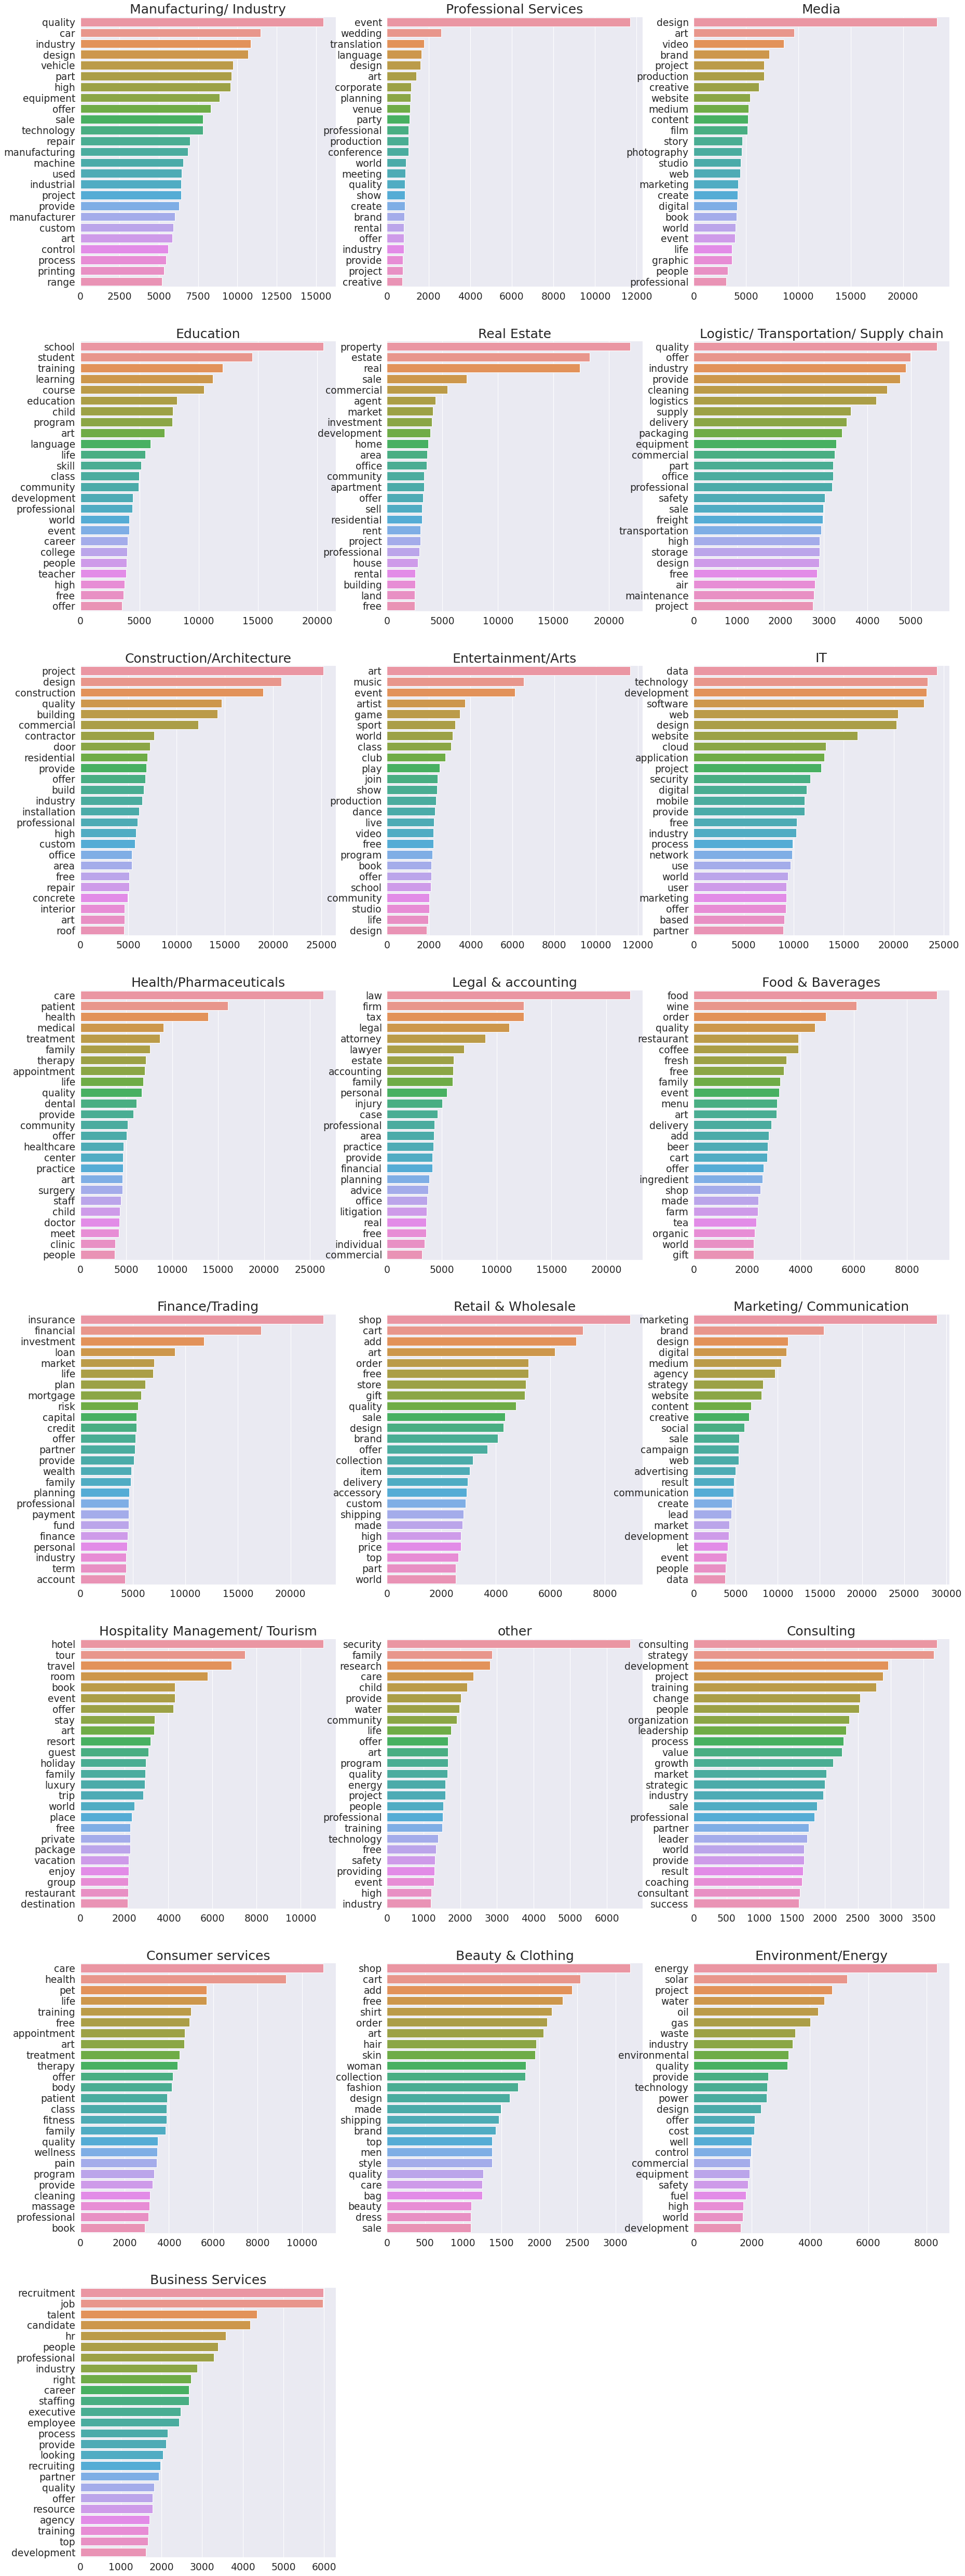

In [ ]:
plot_most_common_in_class_uni('clean', df, most =25)

In [ ]:
"""
The goal is to balance classes in dataset by cutting off larger classes
e.g: A: 100, B:40 -> A: 40 B: 40
"""

'\nThe goal is to balance classes in dataset by cutting off larger classes\ne.g: A: 100, B:40 -> A: 40 B: 40\n'

In [ ]:
df['main industry'].value_counts()

IT                                        27403
Manufacturing/ Industry                   17944
Construction/Architecture                 17207
Media                                     13554
Finance/Trading                           12817
Health/Pharmaceuticals                    11511
Marketing/ Communication                  11274
Education                                 10527
Retail & Wholesale                         9834
Logistic/ Transportation/ Supply chain     9415
Consumer services                          9172
Entertainment/Arts                         8497
Legal & accounting                         8360
Food & Baverages                           7872
Real Estate                                7465
Hospitality Management/ Tourism            6686
Environment/Energy                         5590
Business Services                          4900
Consulting                                 4844
other                                      4179
Beauty & Clothing                       

In [ ]:
def count_kw(text, labels):
    t = text#.split(' ')
    c = 0
    for item in labels:
        if item in t:
            c += 1
    return c
#top_features
DF['count'] = 0
for each in classes:
    labels = top_features[each]
    index = DF.index[ DF['main industry'] == each].tolist()
    for i in index:
        DF.loc[i, ['count']] = count_kw(DF.loc[i]['clean'], labels)
DF['ratio'] = DF['count']/DF.len

In [ ]:
cols = df['main industry'].unique()
list_df = []
n = 10000
for each in cols:
    _df  = df[(df['main industry'] == each) & (df.len >= 10)  & (df['en'] == True) ]
    if len(_df) >= n :
        
        if each in  ['IT']:
            _df = _df[_df['len'] > 15].sample(n= int(0.7 * n))
        elif each in  ['other']:
            _df = _df[_df['len'] > 15].sample(n= int(0.6 * n))
        else:    
            _df = _df.sample(n=n)
        
    list_df.append(_df)


In [ ]:
DF = None
for each in list_df:
    DF = pd.concat([DF, each], ignore_index=True)

In [ ]:
DF['main industry'].value_counts()

Finance/Trading                           10000
Construction/Architecture                 10000
Health/Pharmaceuticals                    10000
Manufacturing/ Industry                   10000
Marketing/ Communication                  10000
Media                                     10000
Education                                  9908
Retail & Wholesale                         9214
Logistic/ Transportation/ Supply chain     8818
Consumer services                          8676
Legal & accounting                         7899
Entertainment/Arts                         7686
Food & Baverages                           7278
IT                                         7000
Real Estate                                6956
Hospitality Management/ Tourism            6282
Environment/Energy                         5189
Business Services                          4540
Consulting                                 4421
other                                      3954
Beauty & Clothing                       

#uni TF-IDF

In [ ]:
uni_tfidf = TfidfVectorizer( min_df=3, max_df=.97, max_features=50000, ngram_range=(1, 2))

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=142)
x_train = uni_tfidf.fit_transform(X_train)
x_test = uni_tfidf.transform(X_test)

### 1.1 MNB

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   51.0s
[Parallel(n_jobs=5)]: Done  70 out of  70 | elapsed:  1.4min finished


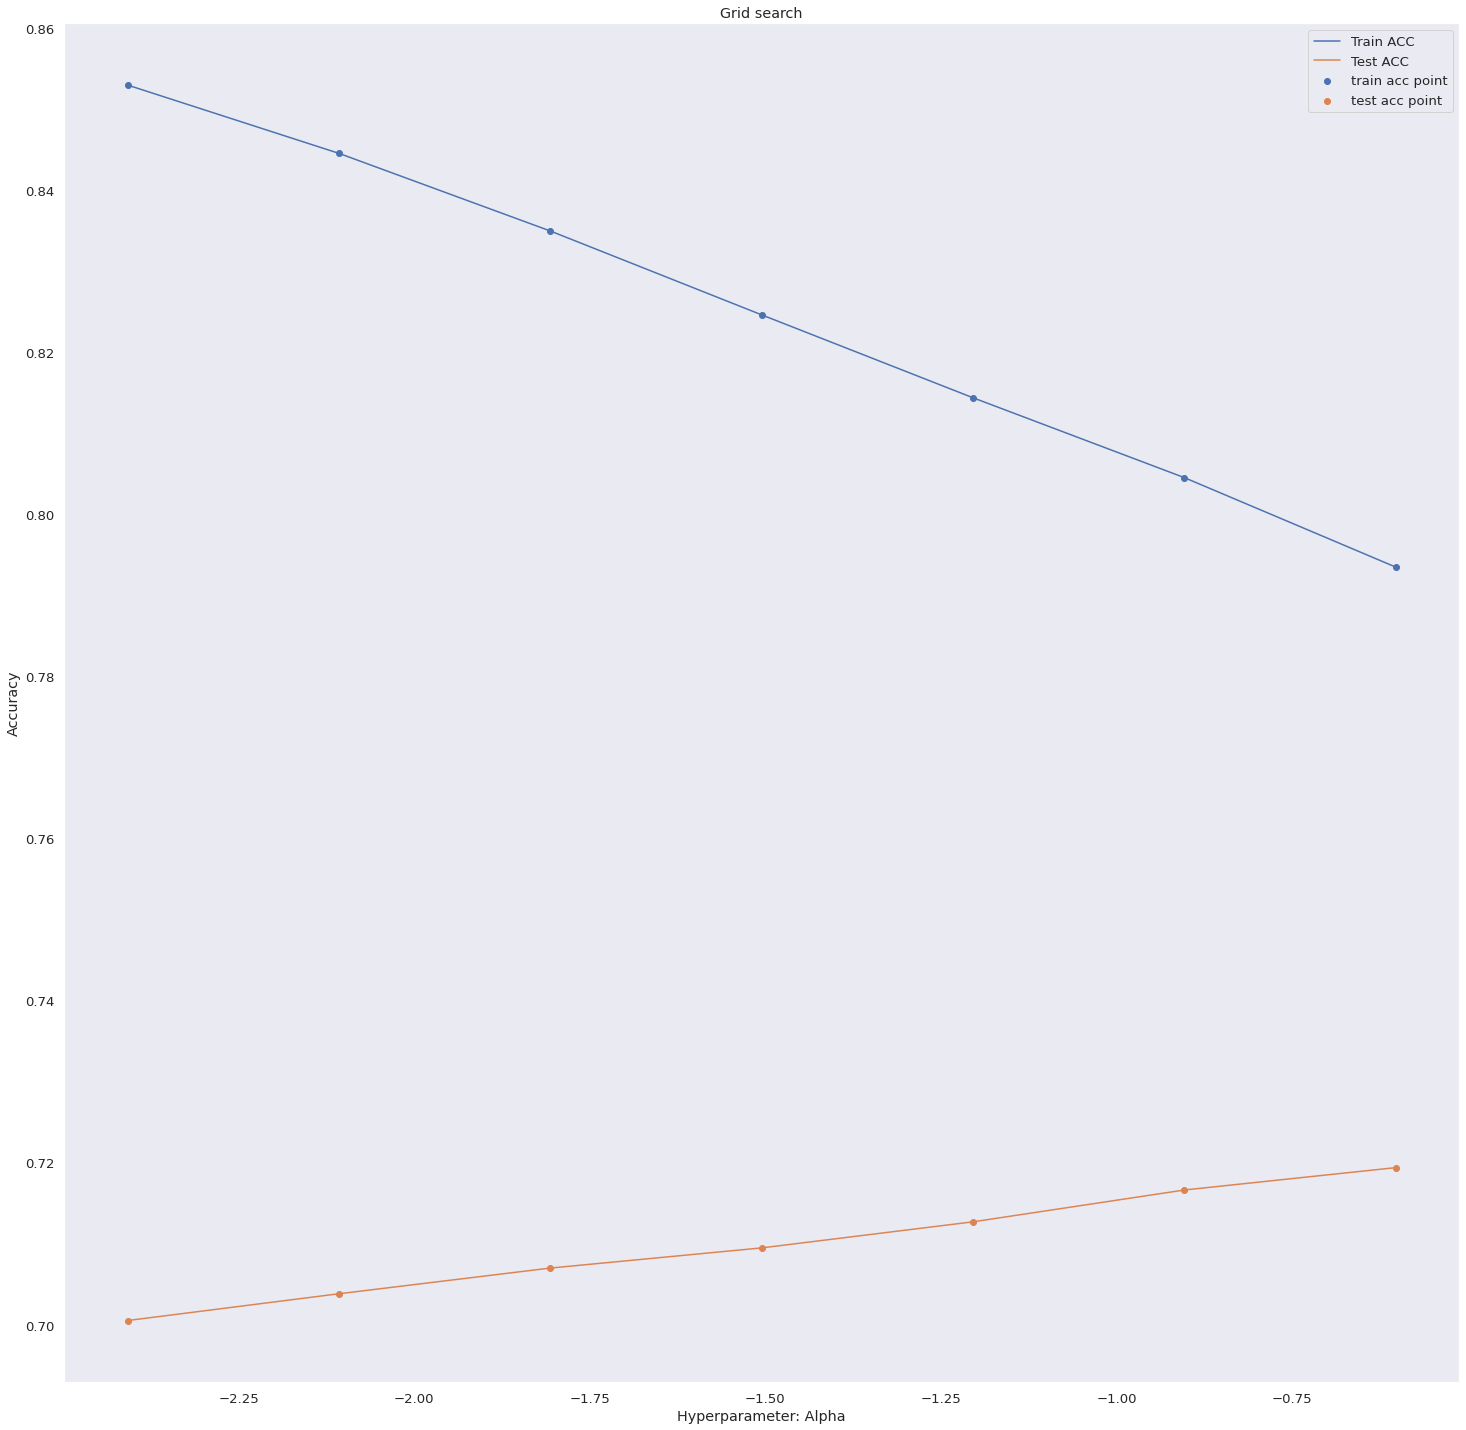

MultinomialNB(alpha=0.25, class_prior=None, fit_prior=False)


In [ ]:
# GRID SEARCH Multinomial Naive Bayes

# tune hyperparameter
# alpha parameter in Multinomial NB 
import math 

grid_params = {'alpha' : [2**x for x in range(-8, -1, 1)]}
alpha_log = [math.log(x, 10) for x in grid_params['alpha']]
#
# socring f1, recall, precision, roc_auc

scorer = make_scorer(metrics.accuracy_score)#, average = 'macro')

MNB = GridSearchCV(MultinomialNB(fit_prior=False), grid_params, scoring=scorer, cv=10, n_jobs=5, return_train_score=True, verbose=1, )
#MNB = MultinomialNB(alpha=0.00175)
MNB.fit(x_train, y_train)

MNB_result = pd.DataFrame.from_dict(MNB.cv_results_)
MNB_result = MNB_result.sort_values(['param_alpha'])

plt.plot(alpha_log, MNB_result["mean_train_score"], label = 'Train ACC')
plt.plot(alpha_log, MNB_result["mean_test_score"], label = 'Test ACC')

plt.scatter(alpha_log, MNB_result['mean_train_score'].values, label='train acc point')
plt.scatter(alpha_log, MNB_result['mean_test_score'].values, label='test acc point')

plt.legend()
plt.xlabel('Hyperparameter: Alpha')
plt.ylabel("Accuracy")

plt.title("Grid search")
plt.grid()
plt.show()

print(MNB.best_estimator_)

In [ ]:
feature_names = np.array(uni_tfidf.get_feature_names())
show_top10_features(MNB.best_estimator_, feature_names, MNB.classes_, 100)

**Business Services**: meet, term, organisation, consultancy, relationship, culture, fit, want, way, deliver, requirement, result, benefit, network, workforce, coaching, based, let, understand, full, contract, cost, leading, recruit, world, approach, temporary, resume, project, providing, value, assistant, finding, leader, recruitment agency, expertise, take, great, global, senior, technology, sale, interview, expert, quality, leadership, focus, permanent, offer, market, success, cv, working, payroll, development, human resource, consulting, office, placement, across, specialist, outsourcing, level, top, skill, training, employment, consultant, firm, staff, opportunity, organization, provide, position, agency, manager, human, role, partner, resource, employer, recruiter, hiring, process, looking, hire, industry, right, employee, professional, people, career, executive, recruiting, staffing, hr, talent, candidate, job, recruitment

**Construction/Architecture**: based, process, highest, throughout, dream, use, supply, specialist, high quality, including, wood, exterior, art, engineer, restoration, fire, working, serving, well, cost, range, top, complete, heating, budget, finish, expert, family, standard, bathroom, tile, designer, general, development, glass, value, quote, contracting, painting, property, full, planning, residential commercial, safety, floor, design build, landscape, estimate, civil, built, stone, steel, providing, house, free, structural, wall, remodeling, water, job, maintenance, industrial, architectural, offer, home, professional, area, flooring, material, industry, office, high, space, plumbing, provide, architecture, renovation, electrical, kitchen, window, repair, furniture, custom, architect, builder, roof, door, interior, build, installation, roofing, concrete, residential, contractor, quality, commercial, building, design, construction, project

**Consulting**: human, hr, small, let, thinking, decision, model, cost, knowledge, practice, assessment, talent, problem, effective, improve, building, better, life, engagement, research, helping, offer, brand, start, corporate, take, analysis, level, across, want, financial, potential, improvement, based, tool, plan, planning, group, right, skill, future, goal, focus, implementation, opportunity, way, deliver, culture, resource, program, insight, grow, design, employee, advisory, working, build, provide, develop, achieve, risk, create, global, expertise, data, technology, world, professional, firm, expert, challenge, impact, approach, marketing, executive, industry, innovation, consultancy, sale, partner, organisation, result, leader, success, market, consultant, value, process, coaching, people, training, growth, project, strategic, organization, change, development, leadership, strategy, consulting

**Consumer services**: providing, full, surgery, use, lifestyle, order, self, stress, treat, child, request, gift, love, look, safe, want, emergency, join, member, mind, session, woman, personal training, medicine, available, loss, way, supplement, better, jewelry, sport, veterinarian, studio, center, goal, practice, staff, injury, healing, take, add, people, doctor, chiropractor, visit, workout, meet, community, provide, professional, feel, cart, physical, quality, well, hospital, weight, exercise, gym, shop, dog, schedule, medical, nutrition, natural, offer, program, book, personal, spa, family, beauty, animal, dental, healthy, veterinary, salon, art, clinic, cleaning, free, class, chiropractic, yoga, training, patient, life, skin, pain, wellness, massage, hair, treatment, body, therapy, appointment, fitness, pet, health, care

**Education**: develop, teach, principal, social, test, safety, policy, primary, activity, member, elementary, message, care, job, center, early, knowledge, lesson, calendar, create, tutor, based, provide, mission, organization, tuition, want, public, take, meet, video, exam, environment, faculty, plan, individual, start, way, classroom, district, join, become, international, learner, offer, future, virtual, science, family, change, coach, programme, success, workshop, academy, apply, level, opportunity, free, high school, resource, admission, grade, book, campus, leader, high, curriculum, library, people, staff, teaching, educational, professional, world, university, event, development, academic, study, community, leadership, life, parent, coaching, career, art, class, teacher, skill, college, language, program, child, education, course, training, learning, student, school

**Entertainment/Arts**: social, like, stage, voice, record, girl, go, wedding, project, special, family, create, level, become, athlete, kid, gaming, workshop, people, director, woman, full, take, camp, love, student, casino, youth, story, offer, piano, audio, musician, session, available, great, award, content, painting, life, free, medium, group, musical, song, league, training, professional, talent, website, guitar, concert, top, age, series, child, member, golf, band, course, creative, art art, coach, book, season, community, recording, fun, dj, soccer, school, football, party, sound, program, festival, lesson, ticket, video, gallery, theatre, live, world, film, join, studio, production, show, player, class, entertainment, play, club, dance, sport, game, event, artist, art, music

**Environment/Energy**: standard, tank, chemical, program, emission, expertise, art, building, professional, heating, expert, provides, use, area, free, facility, pipeline, global, based, future, reduce, leading, pump, heat, removal, inspection, technical, soil, petroleum, asset, material, partner, monitoring, electricity, storage, treatment, market, sustainability, climate, offshore, process, value, wind, land, field, training, high, installation, assessment, efficiency, production, consulting, supply, world, air, data, offer, providing, natural, community, development, operation, testing, construction, green, resource, carbon, commercial, clean, design, tree, industrial, maintenance, control, renewable energy, drilling, environment, provide, well, safety, cost, equipment, plant, recycling, sustainable, technology, quality, renewable, fuel, industry, power, oil gas, project, waste, environmental, water, gas, oil, solar, energy

**Finance/Trading**: program, expertise, fee, transaction, take, let, owner, want, cost, security, opportunity, interest, lending, agent, technology, providing, way, agency, saving, property, meet, employee, based, long term, option, financial planning, estate, real, commercial, free, invest, process, funding, right, global, long, auto, trading, income, member, individual, cash, access, independent, policy, industry, private, growth, debt, group, future, investing, professional, advisory, financing, strategy, offer, goal, value, provide, portfolio, advice, benefit, coverage, rate, claim, family, card, quote, equity, personal, broker, firm, bank, term, money, tax, banking, planning, asset, account, partner, advisor, payment, retirement, life, investor, finance, plan, risk, fund, credit, market, wealth, capital, mortgage, loan, investment, financial, insurance

**Food & Baverages**: plant, party, visit, ice, juice, come, water, range, box, eat, vegetable, sweet, reservation, cocktail, spice, place, spirit, brand, bread, location, chicken, craft, fish, add cart, dish, snack, flavour, buy, milk, cuisine, sauce, beverage, lunch, join, take, cafe, italian, natural, market, world, cream, go, bakery, offer, produce, available, love, table, healthy, store, dairy, dinner, farmer, seafood, kitchen, enjoy, chef, tasting, good, special, great, art, add, local, cart, shop, cheese, meat, made, pizza, free, drink, recipe, flavor, dining, gift, cake, tea, chocolate, event, family, catering, meal, fruit, bar, organic, taste, delicious, delivery, quality, farm, ingredient, menu, fresh, beer, order, coffee, restaurant, wine, food

**Health/Pharmaceuticals**: safety, take, compassionate, better, group, resident, free, state, development, healthy, surgical, training, cell, access, wellness, high, testing, medication, therapist, injury, caring, treat, test, insurance, nurse, plan, therapeutic, based, book, area, emergency, condition, comprehensive, adult, location, available, cosmetic, request, senior, physical, individual, well, technology, research, nursing, teeth, facility, disorder, people, skin, counseling, professional, pharmacy, living, pharmaceutical, program, art, providing, schedule, mental health, visit, dentistry, office, health care, offer, provider, meet, drug, mental, cancer, smile, dentist, physician, eye, child, provide, community, staff, disease, medicine, quality, hospital, pain, practice, center, clinical, clinic, life, doctor, surgery, healthcare, family, appointment, dental, therapy, treatment, medical, health, patient, care

**Hospitality Management/ Tourism**: space, view, drink, boutique, top, price, guide, go, date, relax, plan, lodge, garden, traveler, house, available, catering, friendly, night, area, car, airport, sea, tourism, unique, discover, bedroom, take, heart, meeting, away, safari, activity, venue, location, menu, beautiful, located, check, pool, rate, thing, wine, country, bed, park, free, hotel hotel, great, apartment, visit, perfect, reservation, wedding, island, golf, local, dining, rental, villa, breakfast, explore, group, world, spa, inn, art, special, cruise, family, private, bar, city, beach, place, food, club, suite, enjoy, booking, package, hospitality, accommodation, adventure, offer, restaurant, destination, vacation, event, trip, stay, luxury, guest, book, holiday, resort, room, tour, travel, hotel

**IT**: innovation, meet, great, keep, problem, better, across, focus, expertise, building, simple, touch, web development, control, feature, medium, want, commerce, strategy, start, high, phone, market, working, tech, full, brand, technical, idea, manage, training, value, video, take, way, art, right, people, access, small, web design, hosting, provider, secure, custom, integration, real, let, developer, deliver, easy, organization, software development, communication, infrastructure, professional, expert, game, using, device, consulting, demo, end, content, offer, quality, computer, server, sale, cost, create, internet, build, world, industry, based, tool, provide, marketing, enterprise, partner, free, use, managed, process, network, project, user, digital, mobile, security, application, design, website, cloud, development, technology, web, data, software

**Legal & accounting**: state, tax return, plan, free consultation, effective, quality, transaction, civil, including, focus, legal advice, compensation, child, visa, taxation, full, people, associate, accounting firm, return, finance, area practice, insurance, meet, advisory, bankruptcy, expertise, based, fee, trial, will, public, take, preparation, compliance, resolution, result, cost, expert, counsel, partner, practice area, audit, offer, estate planning, experienced, providing, payroll, small, representation, issue, probate, employment, defense, right, trust, claim, corporate, commercial, property, free, court, bookkeeping, immigration, solicitor, cpa, divorce, real estate, consultation, provide, real, matter, professional, criminal, individual, dispute, family law, office, accident, area, planning, personal injury, advice, financial, practice, family, case, accountant, litigation, personal, estate, injury, law firm, accounting, lawyer, attorney, firm, legal, tax, law

**Logistic/ Transportation/ Supply chain**: price, based, trucking, handling, market, taxi, jet, material, road, network, well, meet, door, load, local, provider, available, across, distribution, take, value, art, area, technology, standard, design, leading, carrier, range, training, warehousing, car, global, warehouse, yacht, vessel, supplier, custom, box, requirement, good, high, free, charter, full, project, world, trailer, safe, move, vehicle, providing, reliable, container, shipment, operation, partner, cost, professional, boat, sale, port, supply chain, fleet, ship, international, repair, chain, marine, facility, commercial, driver, part, aviation, equipment, office, maintenance, quote, truck, flight, safety, offer, airport, air, quality, shipping, provide, industry, cargo, moving, storage, packaging, delivery, supply, aircraft, transport, transportation, cleaning, freight, logistics

**Manufacturing/ Industry**: model, gas, based, engineer, truck, complete, innovative, cable, requirement, installation, commercial, available, used car, development, quote, led, light, oil, use, mechanical, fabrication, owned, motor, lighting, safety, technical, testing, machinery, coating, meet, series, machining, partner, price, providing, certified, facility, full, high quality, assembly, maintenance, chemical, water, cost, test, line, value, air, art, market, tire, steel, dealer, standard, world, automation, print, tool, shop, supplier, manufacture, device, leading, medical, precision, automotive, plastic, metal, component, supply, provide, project, material, range, process, power, offer, custom, production, electrical, application, auto, control, sale, technology, used, industrial, printing, high, manufacturer, design, machine, repair, manufacturing, industry, part, equipment, vehicle, quality, car

**Marketing/ Communication**: real, talk, connect, better, public relation, print, plan, engagement, value, approach, local, channel, google, provide, professional, effective, creating, optimization, custom, target, graphic, small, top, great, production, traffic, start, driven, working, success, drive, offer, based, increase, public, free, technology, relation, like, expert, marketing strategy, deliver, message, goal, take, reach, art, insight, industry, partner, project, touch, way, strategic, want, consumer, full, world, idea, growth, engine, research, right, people, event, story, pr, web design, build, development, video, grow, market, data, let, branding, create, audience, marketing agency, result, sale, ad, social medium, lead, communication, web, social, digital marketing, campaign, advertising, content, creative, website, strategy, design, agency, medium, digital, brand, marketing

**Media**: go, small, campaign, series, unique, industry, design studio, sign, communication, good, latest, writer, set, free, motion, director, corporate, editing, offer, start, strategy, editor, working, tell, thing, high, creating, want, custom, quality, take, look, space, like, logo, publishing, commercial, top, magazine, artist, full, way, audience, show, post, great, social, live, professional, identity, touch, interior design, music, writing, tv, award, people, visual, based, web design, portrait, development, let, idea, life, graphic design, love, image, video production, agency, world, event, animation, print, photo, wedding, designer, branding, create, marketing, book, interior, digital, photographer, web, website, story, medium, graphic, content, project, studio, brand, art, creative, film, photography, production, video, design

**Professional Services**: book, equipment, building, touch, food, plan, photo, based, stand, sound, trade show, flower, come, way, international, private, agency, next, great, meet, package, audience, partner, love, destination, trade, tent, celebration, ceremony, top, special event, content, idea, booth, festival, take, creating, life, memorable, occasion, fun, together, event design, people, video, offer, wedding planner, perfect, interpreting, event planner, let, detail, marketing, project, provide, interpreter, speaker, audio, catering, wedding event, space, quality, entertainment, full, lighting, industry, localization, event event, unique, event production, special, translator, live, guest, world, virtual, brand, professional, creative, hire, create, corporate event, art, event planning, show, exhibition, planner, meeting, rental, design, corporate, production, planning, conference, party, venue, language, translation, wedding, event

**Real Estate**: ca, partner, high, expert, request, way, landlord, firm, right, loan, estate investment, unit, developer, website, quality, estate real, top, sold, available, buying selling, title, opportunity, transaction, leasing, provide, condo, place, process, meet, use, full, worth, term, dream, owner, construction, group, commercial property, brokerage, location, letting, mortgage, asset, looking, retail, luxury, broker, free, seller, local, housing, living, family, let, property property, property sale, street, price, lease, realtor, city, bedroom, offer, valuation, investor, space, value, professional, building, estate agent, project, appraisal, buy, tenant, house, commercial real, realty, buyer, buying, community, land, rental, area, selling, office, development, market, residential, sell, rent, apartment, investment, home, commercial, agent, sale, real, real estate, estate, property

**Retail & Wholesale**: family, dog, way, kit, go, great, book, cart empty, basket, gear, fabric, perfect, right, pet, shipping order, pack, line, ring, hair, retailer, light, care, toy, box, power, equipment, jacket, mask, color, full, good, size, special, fit, look, range, world, designer, energy, powered, wholesale, available, return, love, wear, bike, card, baby, set, part, hand, jewelry, selection, use, leather, flower, apparel, black, buy, retail, high, cart add, empty, stock, offer, top, supply, free shipping, dress, water, shoe, delivery, custom, clothing, men, price, shopping, style, quality, fashion, made, design, sale, add cart, woman, accessory, art, bag, shirt, item, collection, free, brand, shipping, gift, add, order, store, cart, shop

**other**: organization, control, latest, social, connect, right, baptist, request, come, available, hope, use, high, care, area, investigation, office, offer, woman, safe, free, protection, local, education, opportunity, together, water, message, bible, risk, youth, place, sermon, student, fire, building, science, council, become, update, way, government, center, staff, provide, technology, video, safety, meet, state, policy, love, data, christian, believe, resource, access, health, report, watch, development, person, project, plan, website, group, history, school, study, alarm, training, visit, world, meeting, member, program, museum, live, mission, family, faith, child, city, pastor, public, jesus, prayer, people, life, christ, event, join, ministry, art, community, research, god, worship, church, security

Acc = 0.5742824985931345
Report 
                                         precision    recall  f1-score   support

                     Business Services       0.42      0.58      0.48       621
             Construction/Architecture       0.67      0.67      0.67      1018
                     Consumer services       0.57      0.42      0.48       698
                   Defense & Aerospace       0.27      0.44      0.34        48
                                   Edu       0.55      0.58      0.57       661
                    Entertainment/Arts       0.44      0.52      0.48       533
                    Environment/Energy       0.41      0.58      0.48       334
                       Finance/Trading       0.68      0.65      0.66       830
                      Food & Baverages       0.62      0.71      0.66       485
                Health/Pharmaceuticals       0.65      0.59      0.62       812
       Hospitality Management/ Tourism       0.56      0.68      0.62       412
     

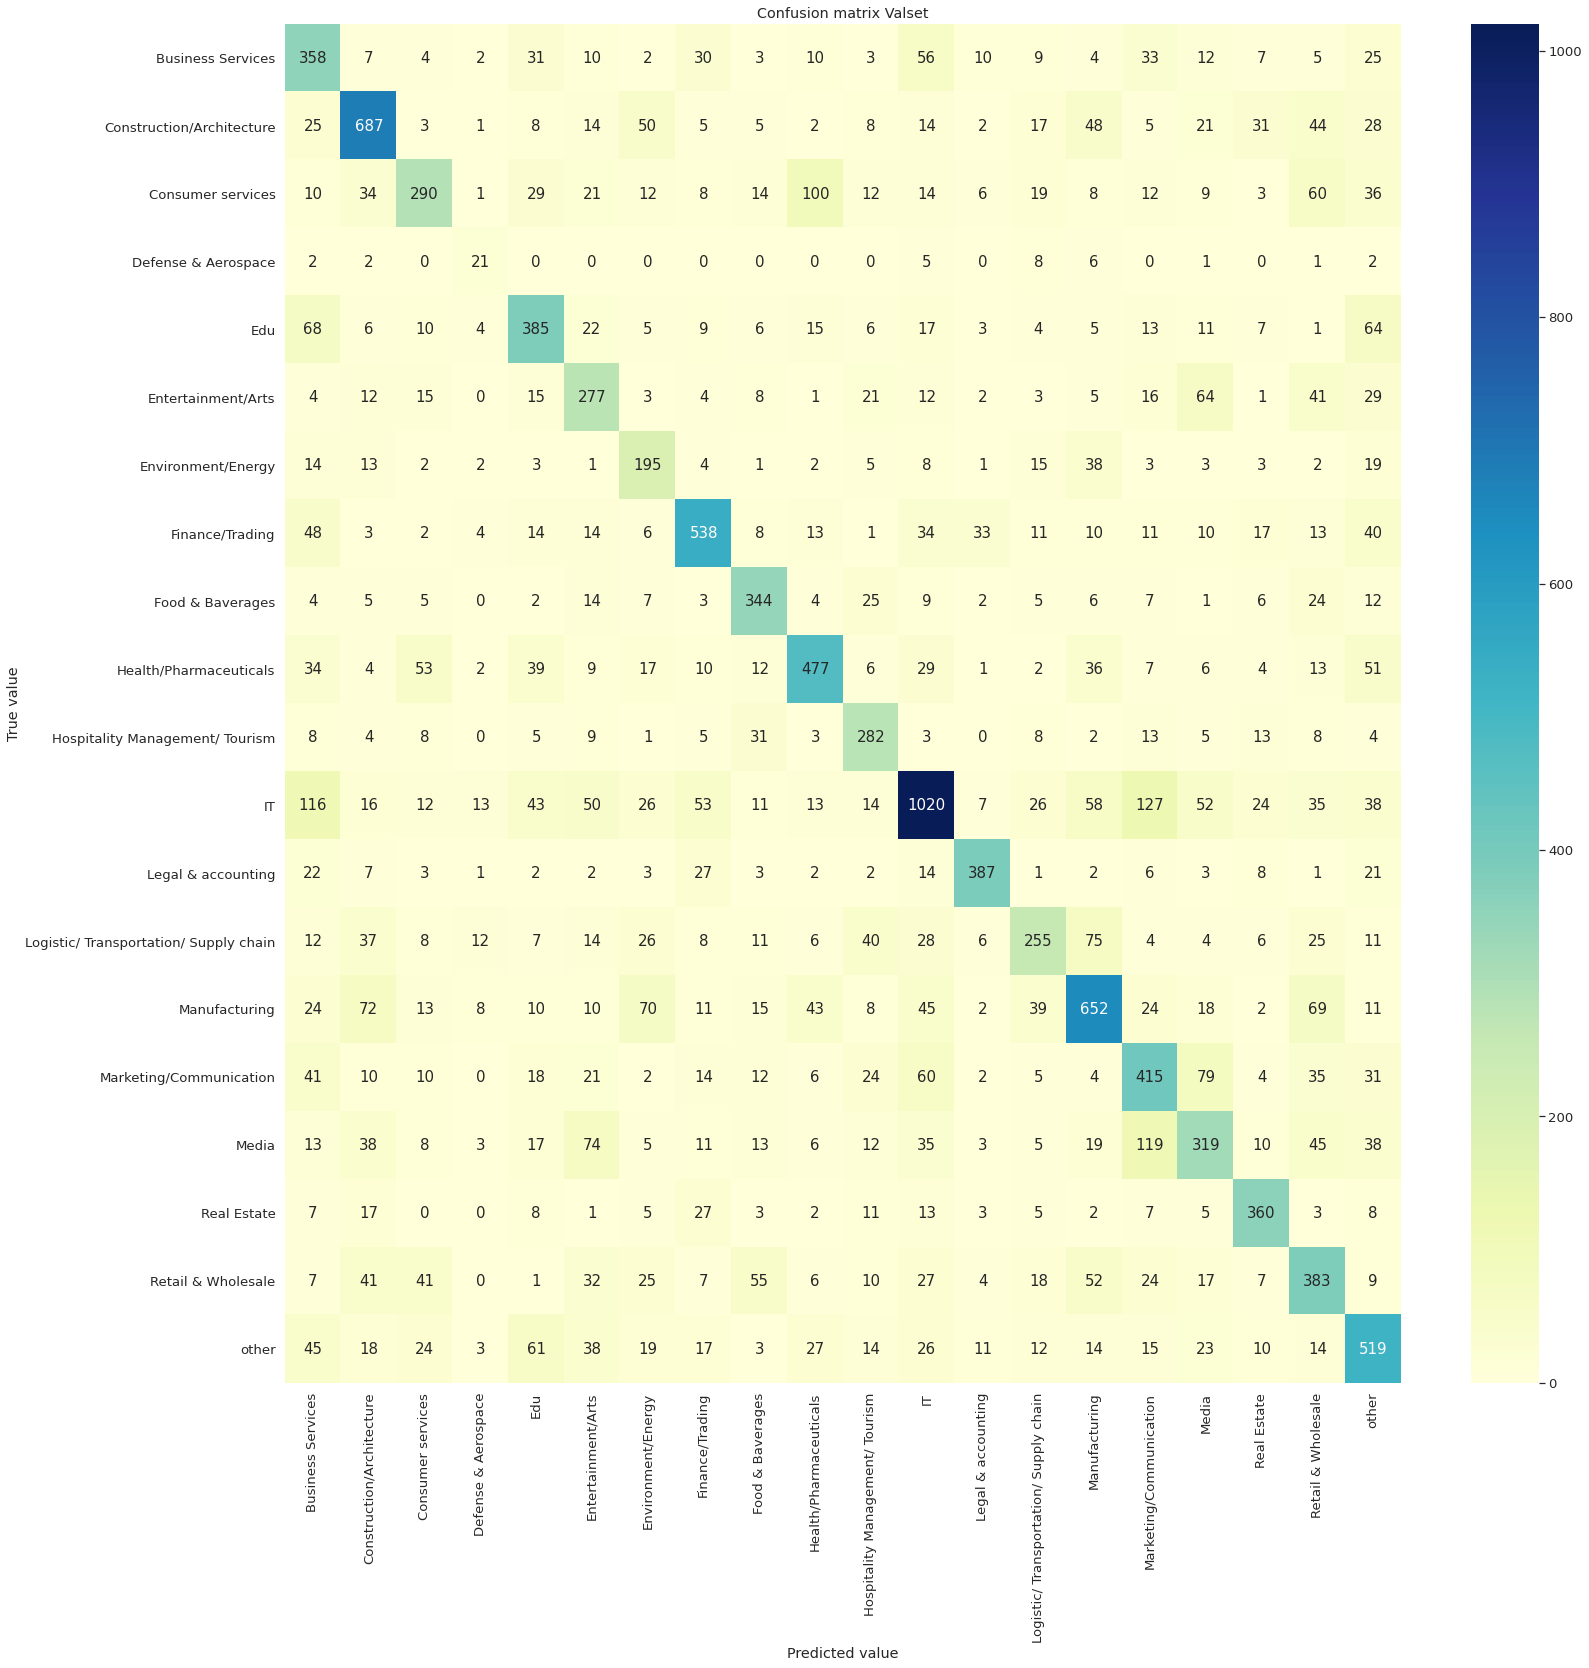

In [ ]:
y_pred = MNB.best_estimator_.predict(x_test)
plot_confusion_matrix(y_test, y_pred, MNB.classes_)

In [ ]:
###### Merging features
top_features = {}
feature_names = np.array(uni_tfidf.get_feature_names())
for i, category in enumerate(classes):
    top10 = np.argsort(MNB.best_estimator_.coef_[i])[-150:]
    #display(Markdown("**%s**: %s" % (category, ", ".join(feature_names[top10]))))
    top_features.update({category : feature_names[top10].tolist()})
#top_features


for i, category in enumerate(classes):
    topsgd = np.argsort(model.coef_[i])[-150:]
    sgd_features = feature_names[topsgd].tolist()
    toplr = np.argsort(clf.coef_[i])[-150:]
    lr_features = feature_names[toplr].tolist()

    mnb_features = top_features[category]
    features = set(mnb_features).intersection(set(lr_features), set(sgd_features) )
    top_features.update({ category : list(features) })

### 1.2 Linear SVC

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  34 out of  40 | elapsed: 150.1min remaining: 26.5min
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed: 152.0min finished


--> best  LinearSVC(C=0.1, class_weight={1: 2}, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=2000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)


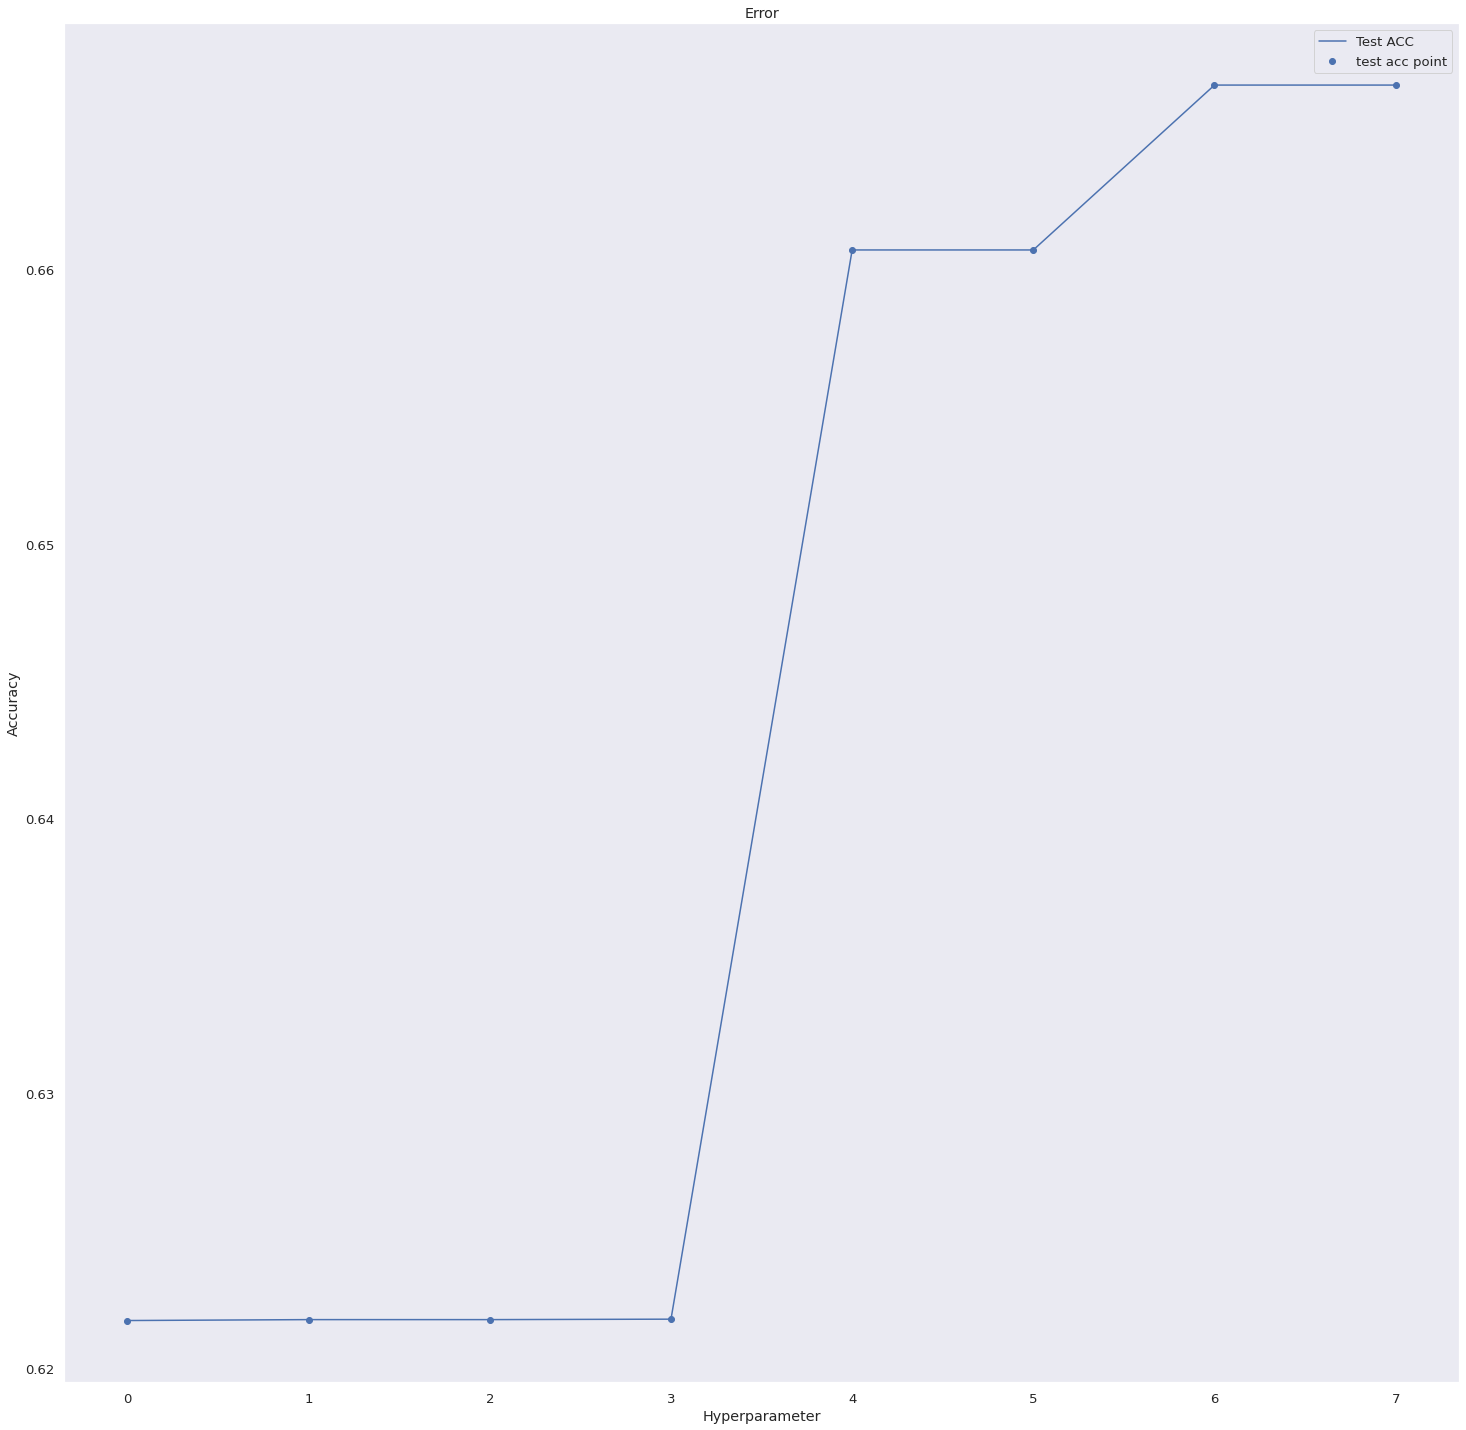

   mean_test_score  std_test_score param_C param_class_weight     param_loss
6         0.621724        0.004337      50             {1: 4}  squared_hinge
4         0.621757        0.004306      50             {1: 2}  squared_hinge
7         0.621757        0.004281      50             {1: 4}             l2
5         0.621774        0.004297      50             {1: 2}             l2
2         0.660697        0.003182     0.1             {1: 4}  squared_hinge
3         0.660697        0.003182     0.1             {1: 4}             l2
0         0.666700        0.003223     0.1             {1: 2}  squared_hinge
1         0.666700        0.003223     0.1             {1: 2}             l2


In [ ]:
le = LabelEncoder()
_y_test = le.fit_transform(y_test)
_y_train = le.fit_transform(y_train)
params = {
    'loss': ['squared_hinge', 'l2'],
    'class_weight' : [{1:2}, {1:4}],
    'C' : [0.1, 50]
}
sv = GridSearchCV(LinearSVC(max_iter=2000), param_grid = [params], verbose = 1, cv = 5, n_jobs = 24, scoring = 'accuracy')
sv.fit(x_train, _y_train)

print(f'--> best  {sv.best_estimator_}')


sv_result = pd.DataFrame.from_dict(sv.cv_results_)
sv_result = sv_result.sort_values(['mean_test_score'])

#plt.plot(alpha_log, sv_result["mean_train_score"], label = 'Train ACC')
x= range(len(sv_result['mean_test_score']))
plt.plot(x, sv_result["mean_test_score"], label = 'Test ACC')

#plt.scatter(alpha_log, sv_result['mean_train_score'].values, label='train acc point')
plt.scatter(x, sv_result['mean_test_score'].values, label='test acc point')

plt.legend()
plt.xlabel('Hyperparameter')
plt.ylabel("Accuracy")

plt.title("Error")
plt.grid()
plt.show()


print(sv_result[['mean_test_score', 'std_test_score', 'param_C', 'param_class_weight', 'param_loss']])

Acc = 0.6666666666666666
Report 
                                  precision    recall  f1-score   support

            Business Management       0.72      0.61      0.66       190
      Construction/Architecture       0.58      0.80      0.67       523
              Defense/aerospace       0.79      0.42      0.55        78
                            Edu       0.68      0.69      0.69       467
             Entertainment/Arts       0.66      0.65      0.66       391
             Environment/Energy       0.66      0.55      0.60       212
                Finance/Trading       0.79      0.81      0.80       457
               Food & Baverages       0.68      0.76      0.72       242
         Health/Pharmaceuticals       0.73      0.80      0.77       454
Hospitality Management/ Tourism       0.74      0.72      0.73       252
                             IT       0.63      0.56      0.59       307
                          Legal       0.84      0.89      0.86       268
       Logistic/

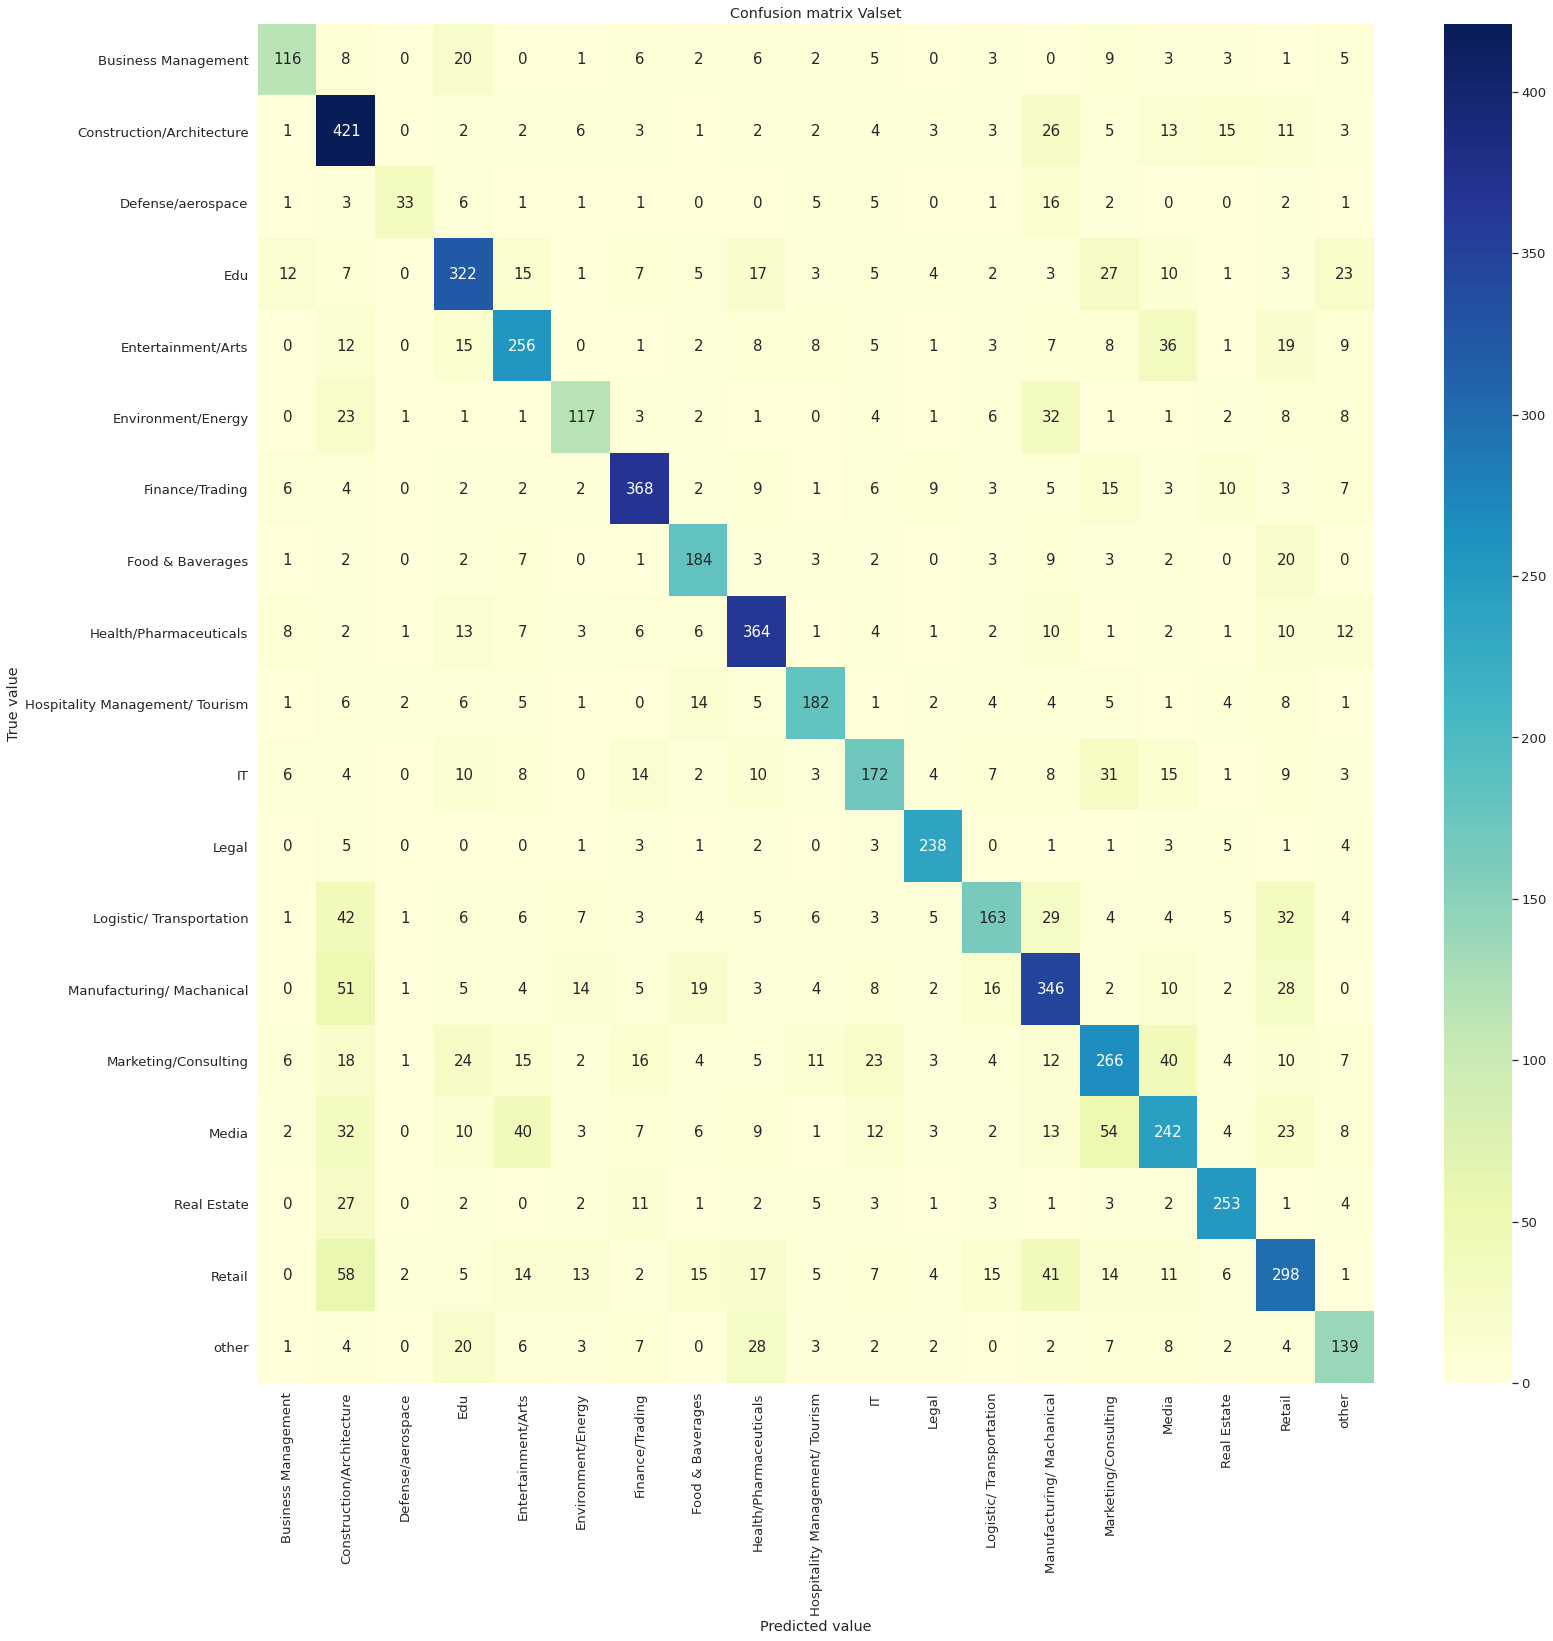

In [ ]:
y_pred = sv.predict(x_test)
plot_confusion_matrix(_y_test, y_pred, classes)

In [ ]:
import joblib

joblib.dump(uni_tfidf, 'unibi_tfidf_0.63.joblib')

['unibi_tfidf_0.63.joblib']

## 1.3 SGD Classifier

In [ ]:
from sklearn.linear_model import SGDClassifier

# Square loss for hard prediction
model = SGDClassifier(loss='squared_hinge', penalty="l2", max_iter=200, verbose=0, n_iter_no_change=10, class_weight=None, learning_rate='adaptive', eta0=0.001)
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.7569504310344828

In [ ]:
# log loss 
model = SGDClassifier(loss='log', penalty="l2", max_iter=1500, verbose=0, n_iter_no_change=10, early_stopping=True,  class_weight='balanced', learning_rate='optimal', eta0=0.01, tol=1e-3)
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.7645059195873872

In [ ]:
model.score(x_train, y_train)

0.7821230205930723

In [ ]:
import sklearn
sklearn.__version__

'0.22.2.post1'

Acc = 0.7850193412261165
Report 
                                         precision    recall  f1-score   support

                     Business Services       0.81      0.71      0.76       539
             Construction/Architecture       0.80      0.88      0.83      1141
                            Consulting       0.61      0.50      0.55       541
                     Consumer services       0.79      0.68      0.73       834
                             Education       0.79      0.84      0.82      1134
                    Entertainment/Arts       0.77      0.76      0.77       674
                    Environment/Energy       0.76      0.72      0.74       478
                       Finance/Trading       0.82      0.84      0.83      1198
                      Food & Baverages       0.79      0.93      0.85       709
                Health/Pharmaceuticals       0.77      0.88      0.82      1059
       Hospitality Management/ Tourism       0.85      0.79      0.82       731
     

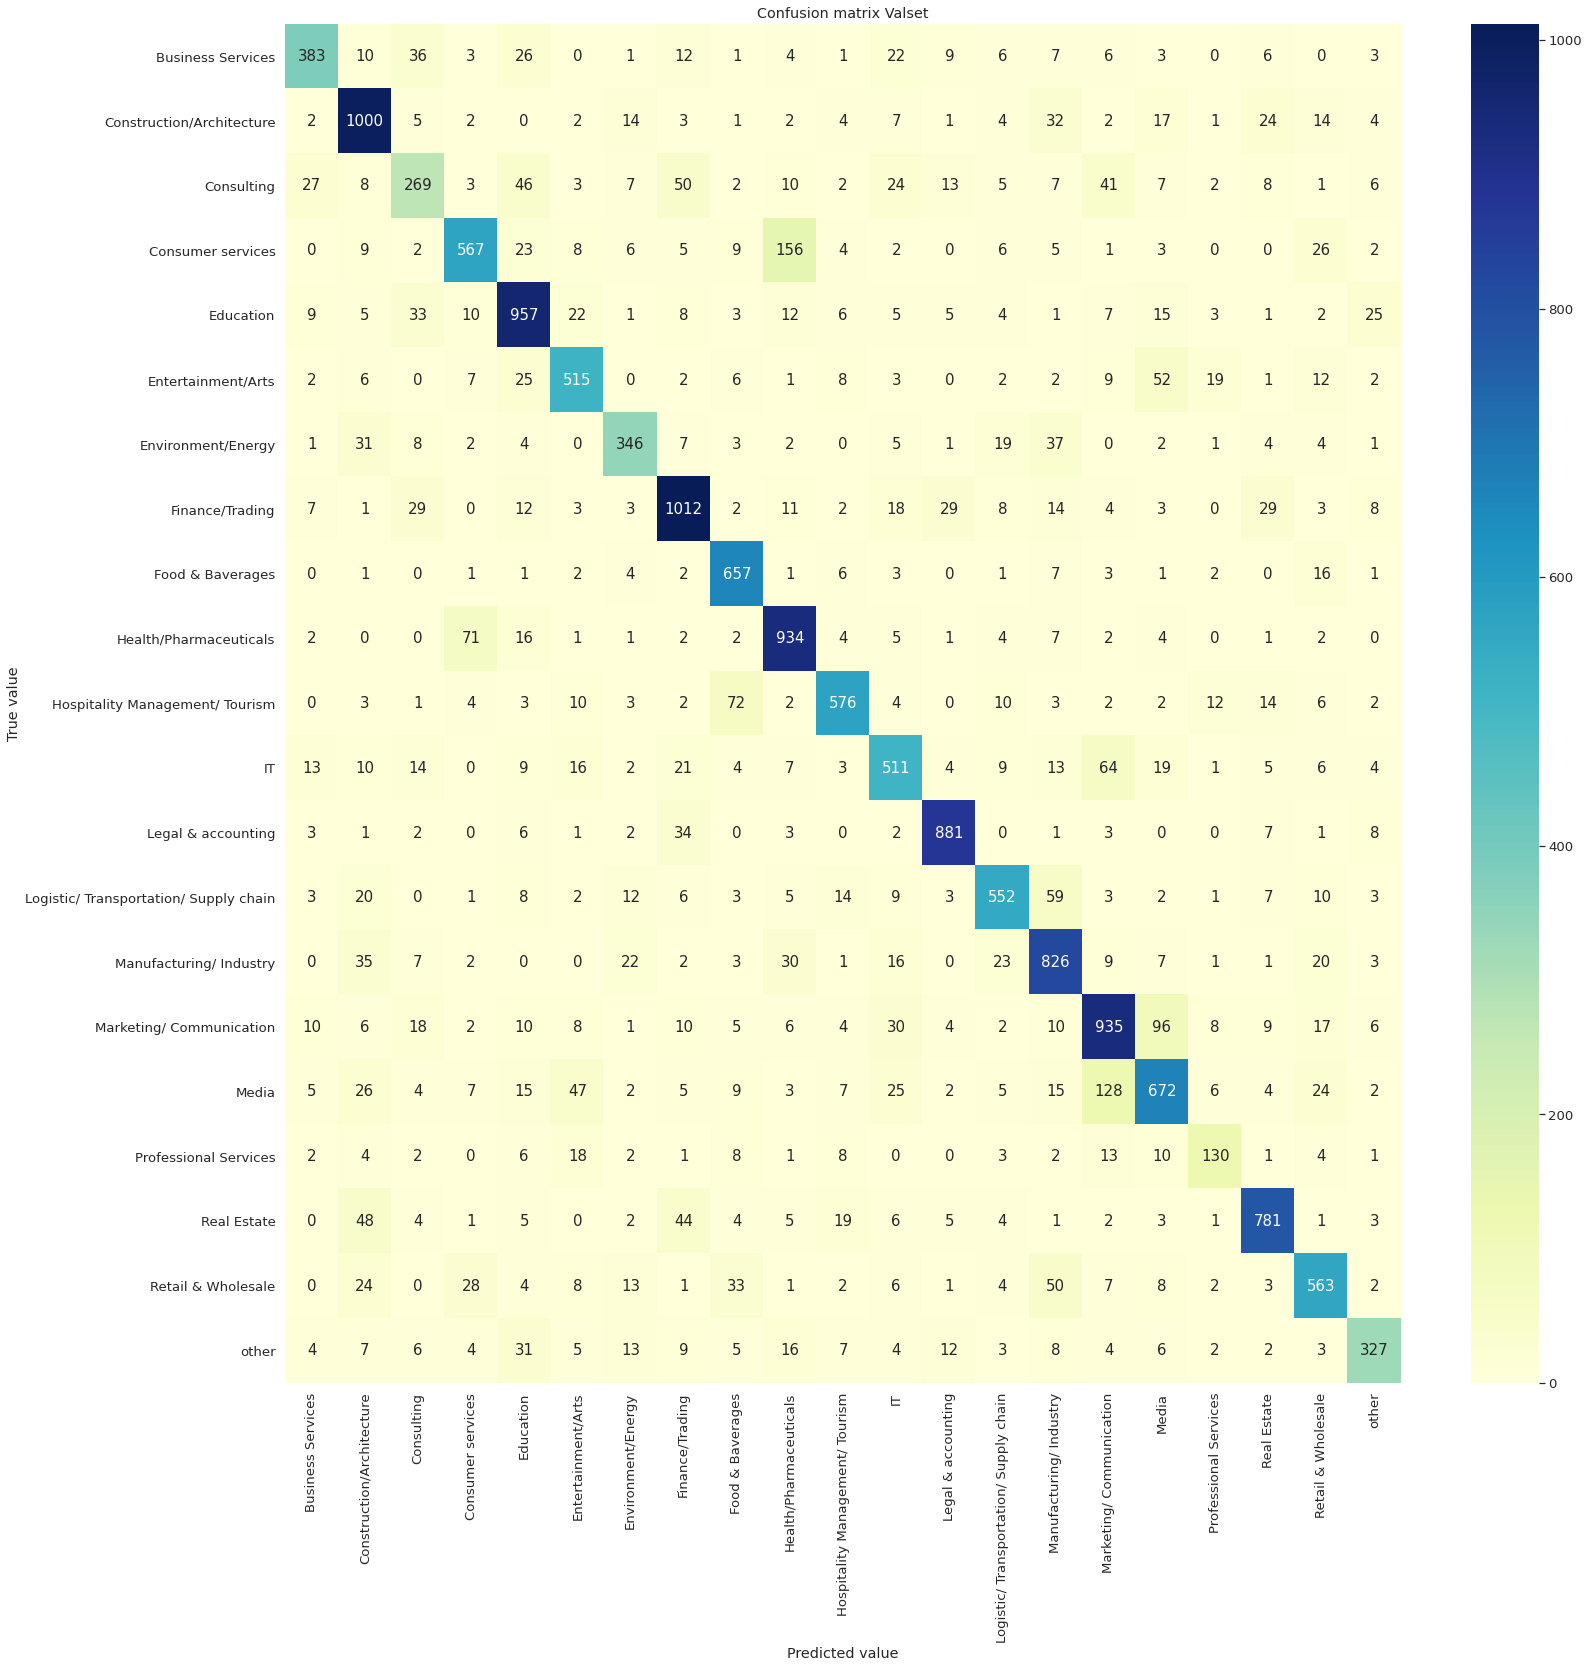

In [ ]:
model2 = SGDClassifier(loss='squared_hinge', penalty="l2", max_iter=200, verbose=0, n_iter_no_change=10, class_weight=None, learning_rate='adaptive', eta0=0.001)
model2.fit(x_train, y_train)
model2.score(x_test, y_test)
y_pred = model2.predict(x_test)
plot_confusion_matrix(y_test, y_pred, classes)

Acc = 0.7569504310344828
Report 
                                         precision    recall  f1-score   support

                     Business Services       0.79      0.70      0.75       588
             Construction/Architecture       0.77      0.83      0.80      1238
                            Consulting       0.59      0.39      0.47       574
                     Consumer services       0.77      0.63      0.69       926
                             Education       0.77      0.82      0.80      1244
                    Entertainment/Arts       0.75      0.74      0.75       757
                    Environment/Energy       0.72      0.67      0.69       563
                       Finance/Trading       0.80      0.83      0.81      1269
                      Food & Baverages       0.81      0.90      0.86       799
                Health/Pharmaceuticals       0.74      0.87      0.80      1131
       Hospitality Management/ Tourism       0.81      0.77      0.79       713
     

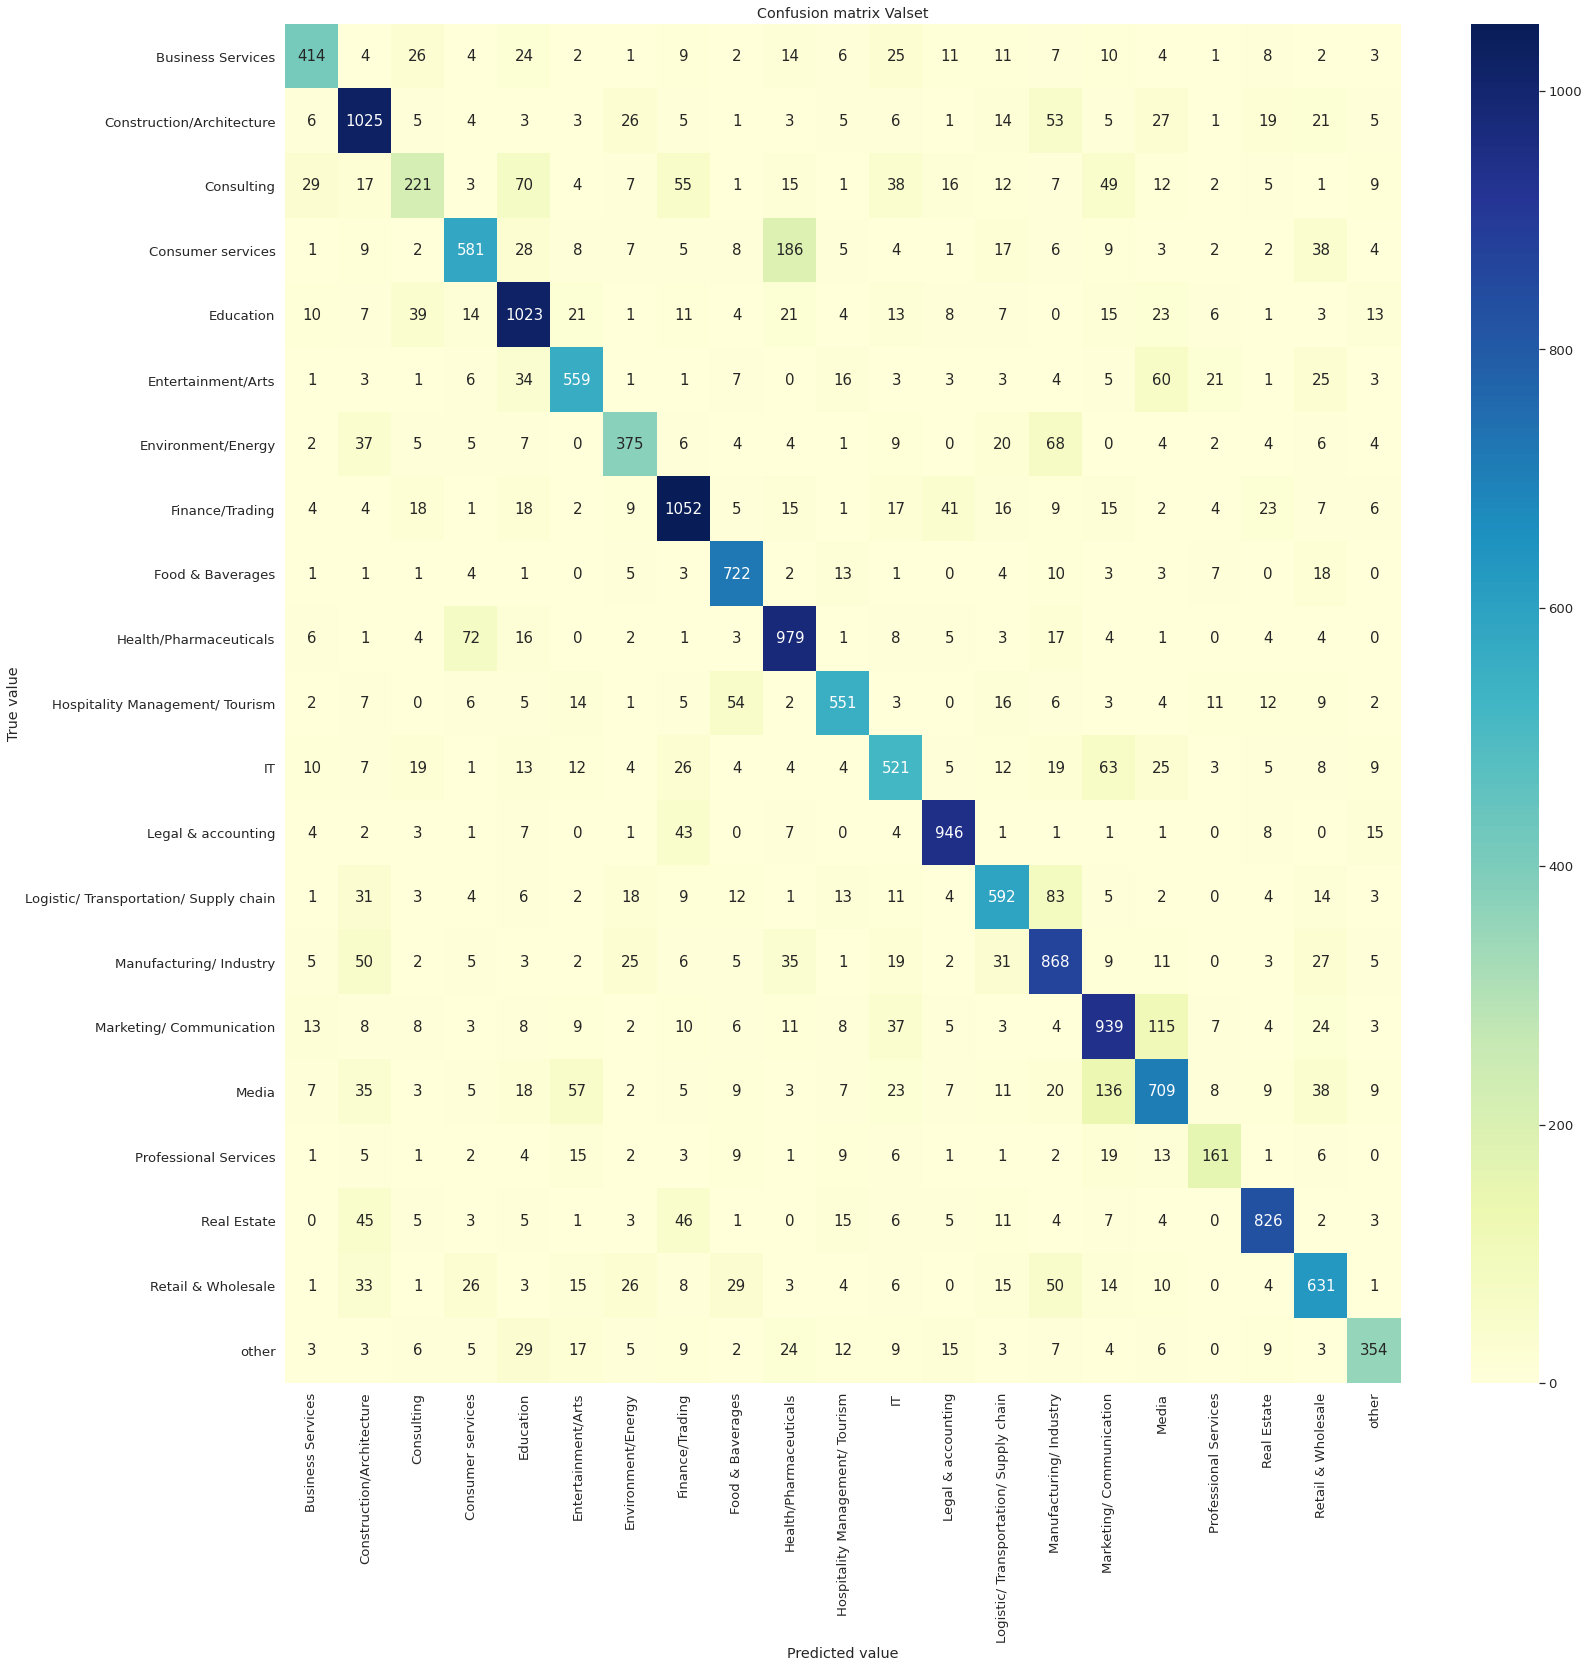

In [ ]:
y_pred = model.predict(x_test)
plot_confusion_matrix(y_test, y_pred, classes)

In [ ]:
feature_names_sgd = np.array(uni_tfidf.get_feature_names())
top20 = show_top10_features(model, feature_names_sgd, classes, 20)

**Business Services**: human, role, placement, assistant, people, career, hiring, human resource, employee, employer, outsourcing, recruiter, executive, talent, recruiting, job, staffing, hr, candidate, recruitment

**Construction/Architecture**: renovation, flooring, stone, civil, structural, roof, plumbing, door, installation, architectural, furniture, project, builder, roofing, building, architecture, contractor, concrete, architect, construction

**Consulting**: thinking, coaching, organizational, value, success, process, advisory, innovation, implementation, improvement, growth, organisation, consultancy, strategic, leadership, organization, change, consultant, strategy, consulting

**Consumer services**: pilate, chiropractic, supplement, skin, exercise, gym, animal, workout, health, nutrition, beauty, hair, veterinary, massage, wellness, body, salon, pet, yoga, fitness

**Education**: teacher, educational, campus, parent, language, university, academic, admission, career, coaching, child, training, library, skill, college, course, education, student, learning, school

**Entertainment/Arts**: recording, league, season, dj, gallery, football, show, ticket, club, art, soccer, game, play, sport, entertainment, player, theatre, dance, artist, music

**Environment/Energy**: soil, environment, oilfield, pipeline, carbon, conservation, renewable, sustainable, tree, drilling, water, recycling, fuel, oil gas, gas, oil, waste, solar, energy, environmental

**Finance/Trading**: risk, benefit, money, mortgage, advisor, trading, investing, payment, retirement, bank, finance, banking, credit, fund, loan, wealth, investment, capital, financial, insurance

**Food & Baverages**: organic, bakery, cheese, cake, menu, chocolate, delicious, meat, order, flavor, fruit, ingredient, farm, fresh, taste, beer, coffee, restaurant, wine, food

**Health/Pharmaceuticals**: cancer, hospital, eye, treatment, disease, therapeutic, medicine, doctor, physician, pharmacy, medical, healthcare, surgery, counseling, therapy, clinical, drug, pharmaceutical, care, patient

**Hospitality Management/ Tourism**: breakfast, luxury, booking, cruise, destination, safari, inn, adventure, guest, stay, accommodation, vacation, room, hospitality, trip, resort, holiday, tour, travel, hotel

**IT**: telecom, integration, demo, infrastructure, developer, development, user, network, server, internet, managed, computer, mobile, enterprise, application, web, technology, data, cloud, software

**Legal & accounting**: criminal, advice, immigration, injury, law firm, case, court, dispute, solicitor, cpa, bookkeeping, litigation, firm, tax, accountant, lawyer, accounting, legal, attorney, law

**Logistic/ Transportation/ Supply chain**: container, boat, shipment, shipping, storage, driver, ship, airport, cleaning, cargo, flight, aviation, marine, moving, packaging, transport, freight, transportation, aircraft, logistics

**Manufacturing/ Industry**: plastic, machinery, industry, dealer, control, equipment, print, automation, part, precision, used, industrial, auto, automotive, manufacturing, car, machine, manufacturer, vehicle, printing

**Marketing/ Communication**: audience, market research, creative, digital, insight, research, consumer, lead, public relation, relation, promotional, ad, medium, pr, communication, campaign, agency, brand, advertising, marketing

**Media**: tv, author, interior, designer, animation, creative, video, photo, production, portrait, story, graphic, studio, editor, publishing, magazine, film, design, photographer, photography

**Professional Services**: expo, interpreting, event production, tent, planning, meeting, event planning, party, rental, planner, interpreter, translator, localization, language, venue, exhibition, conference, wedding, translation, event

**Real Estate**: title, space, development, housing, buyer, land, tenant, community, sell, appraisal, real, rent, realtor, agent, home, realty, apartment, estate, real estate, property

**Retail & Wholesale**: men, shipping, style, order, shoe, jewelry, gift, wholesale, item, collection, bag, apparel, cart, dress, fashion, clothing, shirt, accessory, shop, store

**other**: history, join, meeting, public, faith, investigation, city, christ, pastor, alarm, council, jesus, prayer, god, museum, research, ministry, worship, security, church

In [ ]:
_top20_df = { 'Industry' : [], 'Most 20 Keywords' : [] , 'Number of samples' : []}
val_counts = df['main industry'].value_counts()
for i, category in enumerate(classes):
    top10 = np.argsort(model.coef_[i])[-20:]
    _top20_df['Industry'].append(category)
    _top20_df['Number of samples'].append(val_counts[category])
    _top20_df['Most 20 Keywords'].append(', '.join(feature_names_sgd[top10]))

pd.DataFrame(_top20_df).to_csv('top20.csv')

In [ ]:
import json
with open('top_features_120.json', 'w') as fp:
    json.dump(top_features, fp)

In [ ]:
import json
with open('top_features_200.json', 'r') as fp:
    top_features = json.load(fp)

In [ ]:
top_features['Education']

### validate data

In [ ]:
preds = model.predict(uni_tfidf.transform(X_train))
_temp = pd.DataFrame({'predict' : preds.tolist()})
_df= pd.concat([DF[['clean', 'main industry', 'industry']], _temp], axis=1)


In [ ]:
top_features['Media']

In [ ]:
_df[(_df['main industry'] != _df['predict'])  & (_df['main industry'] == 'Marketing/Consulting')] [:20000]

In [ ]:
sv.predict( uni_tfidf.transform(['']) )

array([8])

In [ ]:

# get feature by coef of mdoel and features of TFIDF
top_features = {}
feature_names = np.array(uni_tfidf.get_feature_names())
for i, category in enumerate(MNB.classes_):
    top10 = np.argsort(model.coef_[i])[-160:]
    #display(Markdown("**%s**: %s" % (category, ", ".join(feature_names[top10]))))
    top_features.update({category : feature_names[top10].tolist()})



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
count_kw_df(top_features, df, 'count')
df['ratio'] = df['count'] / df['len']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [ ]:
DF.to_csv('data_kw_sgd.csv')

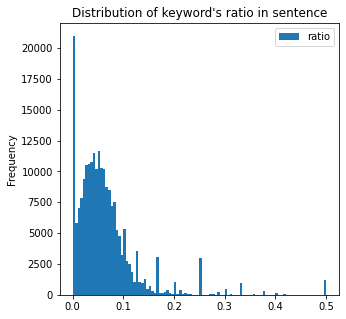

In [ ]:
plt.rcParams["figure.figsize"] = (5,5)
df.plot(kind='hist', y='ratio', bins=100, title="Distribution of keyword's ratio in sentence")

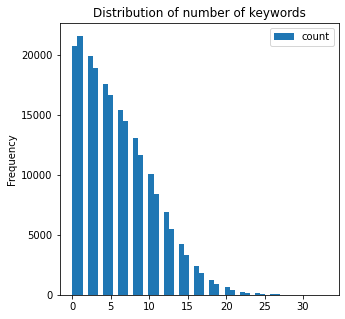

In [ ]:
df.plot(kind='hist', y='count', bins=50, title='Distribution of number of keywords')

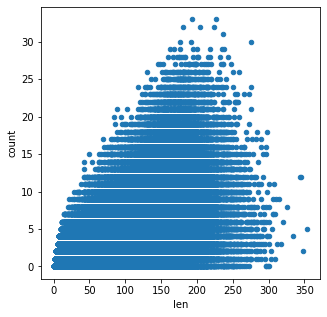

In [ ]:
df.plot(kind='scatter', y='count', x='len')

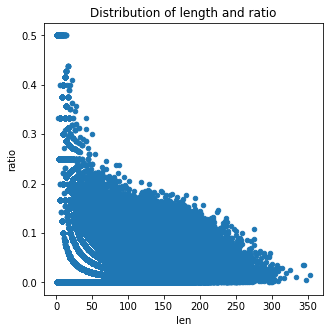

In [ ]:
df.plot(kind='scatter', y='ratio', x='len', title='Distribution of length and ratio')

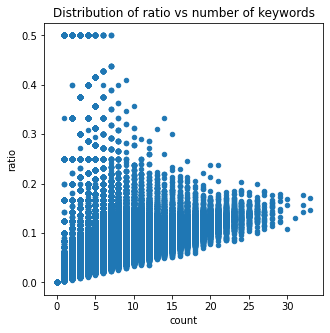

In [ ]:
df.plot(kind='scatter', y='ratio', x='count', title="Distribution of ratio vs number of keywords")

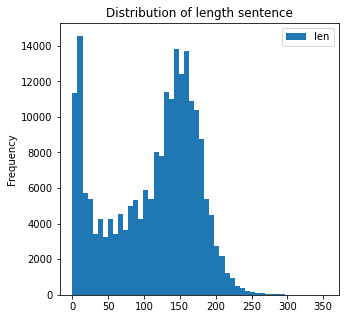

In [ ]:
df.plot(kind='hist', y='len', bins=50, title='Distribution of length sentence')

In [ ]:
_DF[(_DF['ratio'] <= 0.07) & (_DF['count'] <= 5)][['clean', 'industry', 'main industry', 'len', 'ratio']]

In [ ]:
df.to_csv('v1data.csv')

## 1.4 Logistic Regres

In [ ]:
clf = LogisticRegression(C=1.5, solver='lbfgs', class_weight='balanced',
                         multi_class='multinomial', max_iter=100, n_jobs=5, random_state=40, verbose=1)
clf.fit(x_train, y_train)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:  1.5min finished


LogisticRegression(C=1.5, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=5,
                   penalty='l2', random_state=40, solver='lbfgs', tol=0.0001,
                   verbose=1, warm_start=False)

Acc = 0.7861915367483296
Report 
                                         precision    recall  f1-score   support

                     Business Services       0.79      0.74      0.76       539
             Construction/Architecture       0.84      0.83      0.83      1141
                            Consulting       0.49      0.65      0.56       541
                     Consumer services       0.76      0.71      0.73       834
                             Education       0.85      0.78      0.81      1134
                    Entertainment/Arts       0.77      0.81      0.79       674
                    Environment/Energy       0.73      0.81      0.77       478
                       Finance/Trading       0.86      0.81      0.84      1198
                      Food & Baverages       0.83      0.91      0.87       709
                Health/Pharmaceuticals       0.81      0.82      0.81      1059
       Hospitality Management/ Tourism       0.85      0.80      0.82       731
     

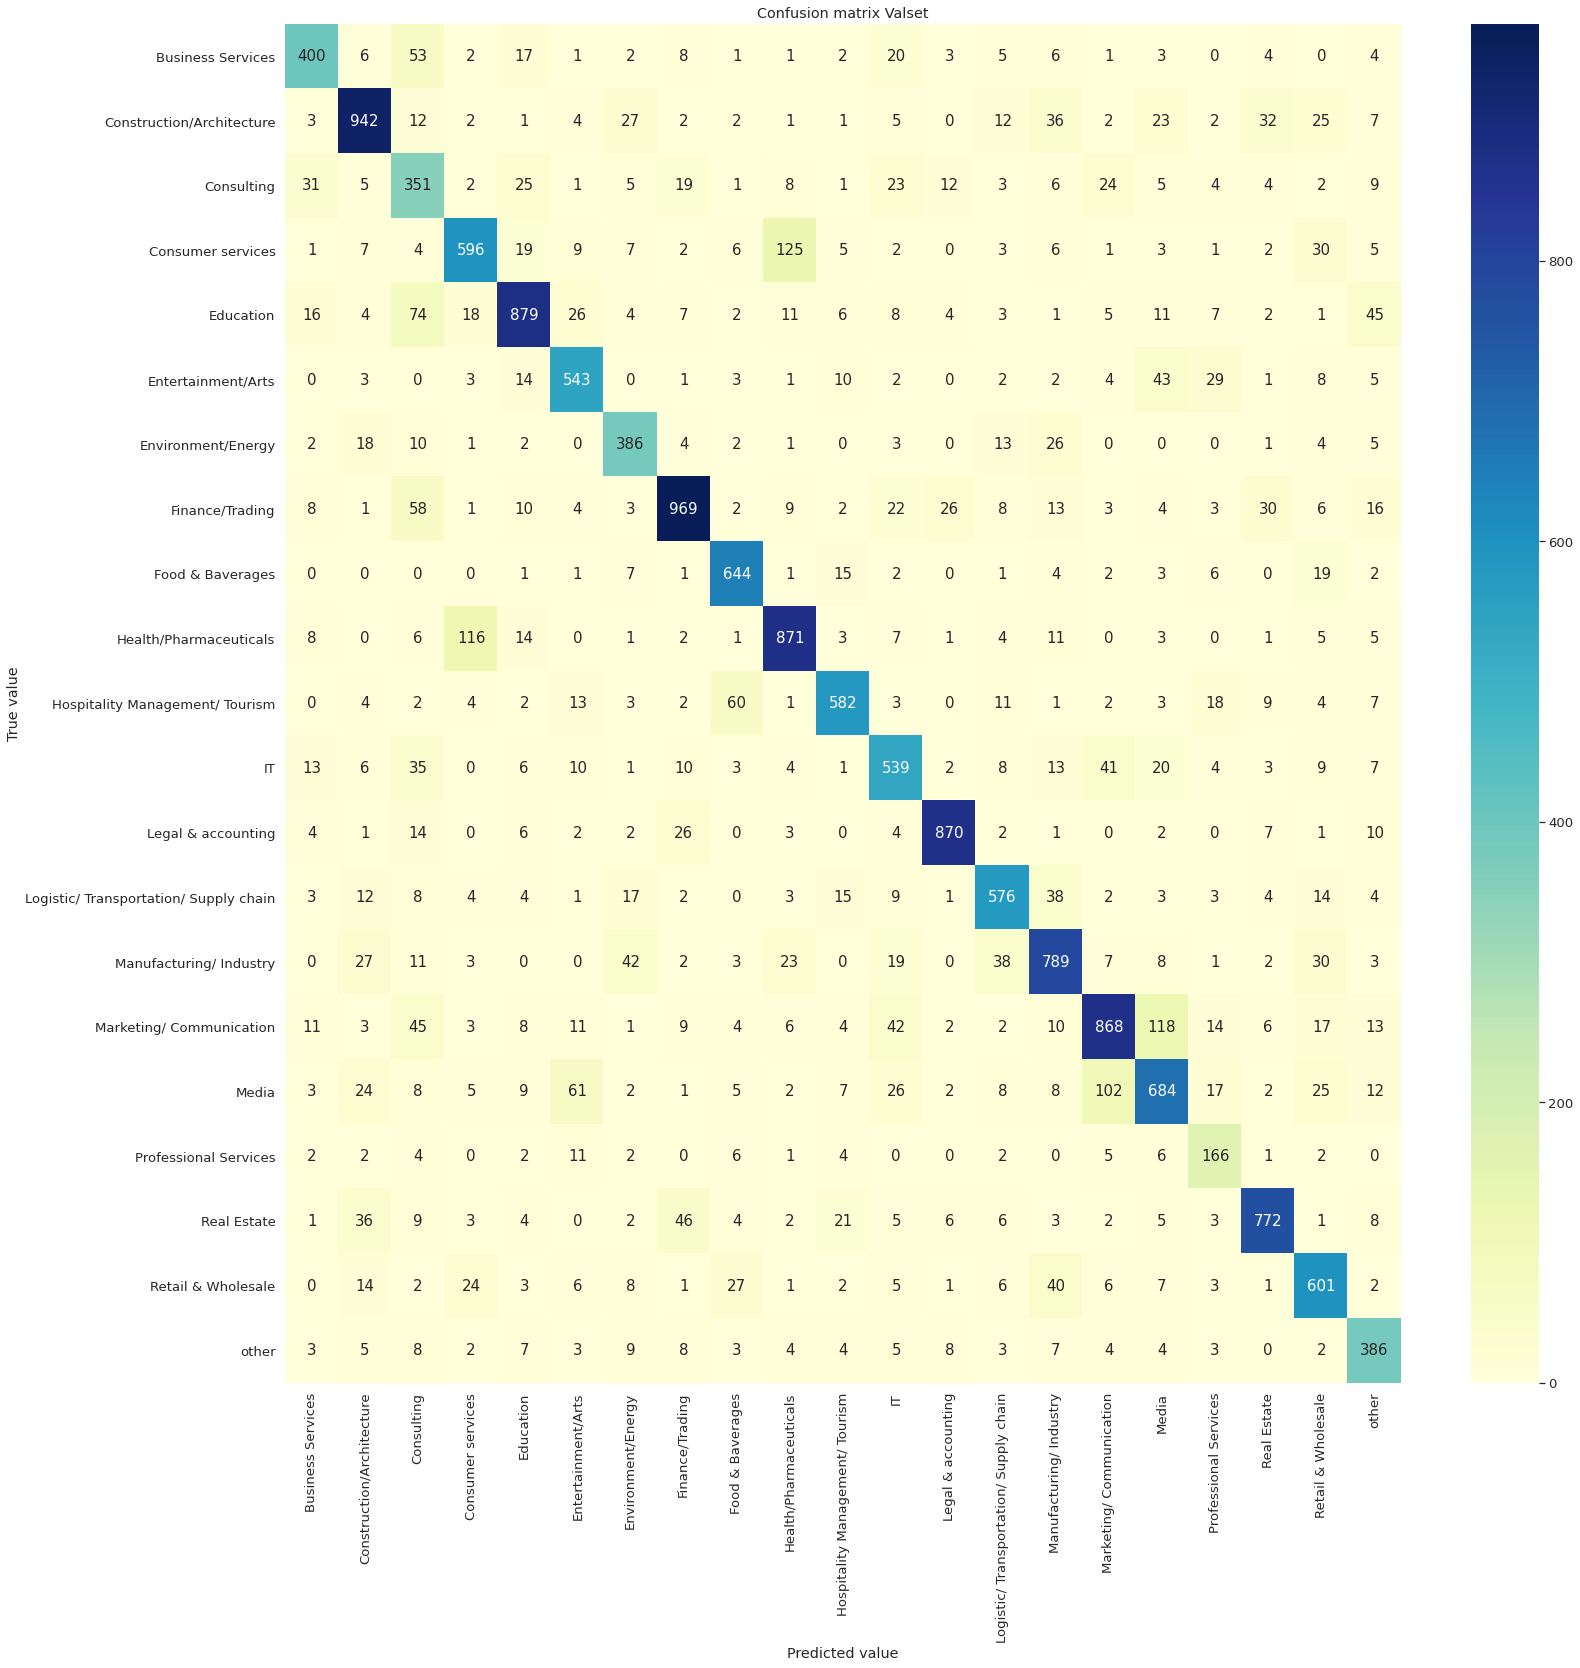

In [ ]:
y_pred = clf.predict(x_test)
plot_confusion_matrix(y_test, y_pred, classes)

In [ ]:
feature_names_lr = np.array(uni_tfidf.get_feature_names())
show_top10_features(clf, feature_names_lr, clf.classes_, 100)

In [ ]:
top_features = {}
feature_names = np.array(uni_tfidf.get_feature_names())

for i, category in enumerate(classes):
    topsgd = np.argsort(model.coef_[i])[-120:]
    sgd_features = feature_names[topsgd].tolist()
    toplr = np.argsort(clf.coef_[i])[-120:]
    lr_features = feature_names[toplr].tolist()
    features = set( sgd_features + lr_features) 
    top_features.update({ category : list(features) })

In [ ]:
y_predicted = clf.predict(x_test)
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted)
print("Validate accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

y_predicted_train = clf.predict(x_train)
accuracy, precision, recall, f1 = get_metrics(y_train, y_predicted_train)
print("Train accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

Validate accuracy = 0.734, precision = 0.738, recall = 0.734, f1 = 0.735
Train accuracy = 0.841, precision = 0.843, recall = 0.841, f1 = 0.840




## 1.5 Voting Classifier

In [ ]:
from sklearn.ensemble import VotingClassifier

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import NearestNeighbors
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier

In [ ]:
vclf_sgd = VotingClassifier(estimators=[
         #('xb6', XGBClassifier(max_depth=6, n_estimators=200, objective='multi:softprob', learning_rate=0.01)),
        #('mb', MultinomialNB(alpha=0.125)),
        ('lr', LogisticRegression(C=1.5, solver='lbfgs', class_weight='balanced',
                         multi_class='multinomial', max_iter=300, n_jobs=5, random_state=40, verbose=1)),
        #('lr2', LogisticRegression(C=1., solver='newton-cg', class_weight='balanced',
        #                 multi_class='multinomial', max_iter=300, n_jobs=5, random_state=40, verbose=1)),
        ('sgd', SGDClassifier(loss='log', penalty="l2", max_iter=1500, verbose=1, n_iter_no_change=25, early_stopping=True,  class_weight='balanced', learning_rate='optimal', eta0=0.1, tol=1e-3) ),
        #('u_sgd', SGDClassifier(loss='log', penalty="l2", max_iter=1500, verbose=1, n_iter_no_change=25, early_stopping=True,  class_weight='balanced', learning_rate='adaptive', eta0=0.1, tol=1e-3) ),
], voting='soft', n_jobs=-1)
vclf_sgd.fit(x_train, y_train)



VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.5, class_weight='balanced',
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=300,
                                                 multi_class='multinomial',
                                                 n_jobs=5, penalty='l2',
                                                 random_state=40,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=1, warm_start=False)),
                             ('sgd',
                              SGDClassifier(alpha=0.0001, average=False,
                                            class_weight='balanced',
                                            early_stopping=True, epsilon=0.1,
                         

Acc = 0.7863673660766616
Report 
                                         precision    recall  f1-score   support

                     Business Services       0.79      0.73      0.76       539
             Construction/Architecture       0.84      0.83      0.83      1141
                            Consulting       0.50      0.64      0.56       541
                     Consumer services       0.78      0.72      0.75       834
                             Education       0.85      0.78      0.81      1134
                    Entertainment/Arts       0.76      0.80      0.78       674
                    Environment/Energy       0.72      0.80      0.76       478
                       Finance/Trading       0.86      0.81      0.84      1198
                      Food & Baverages       0.82      0.91      0.86       709
                Health/Pharmaceuticals       0.81      0.84      0.82      1059
       Hospitality Management/ Tourism       0.85      0.79      0.82       731
     

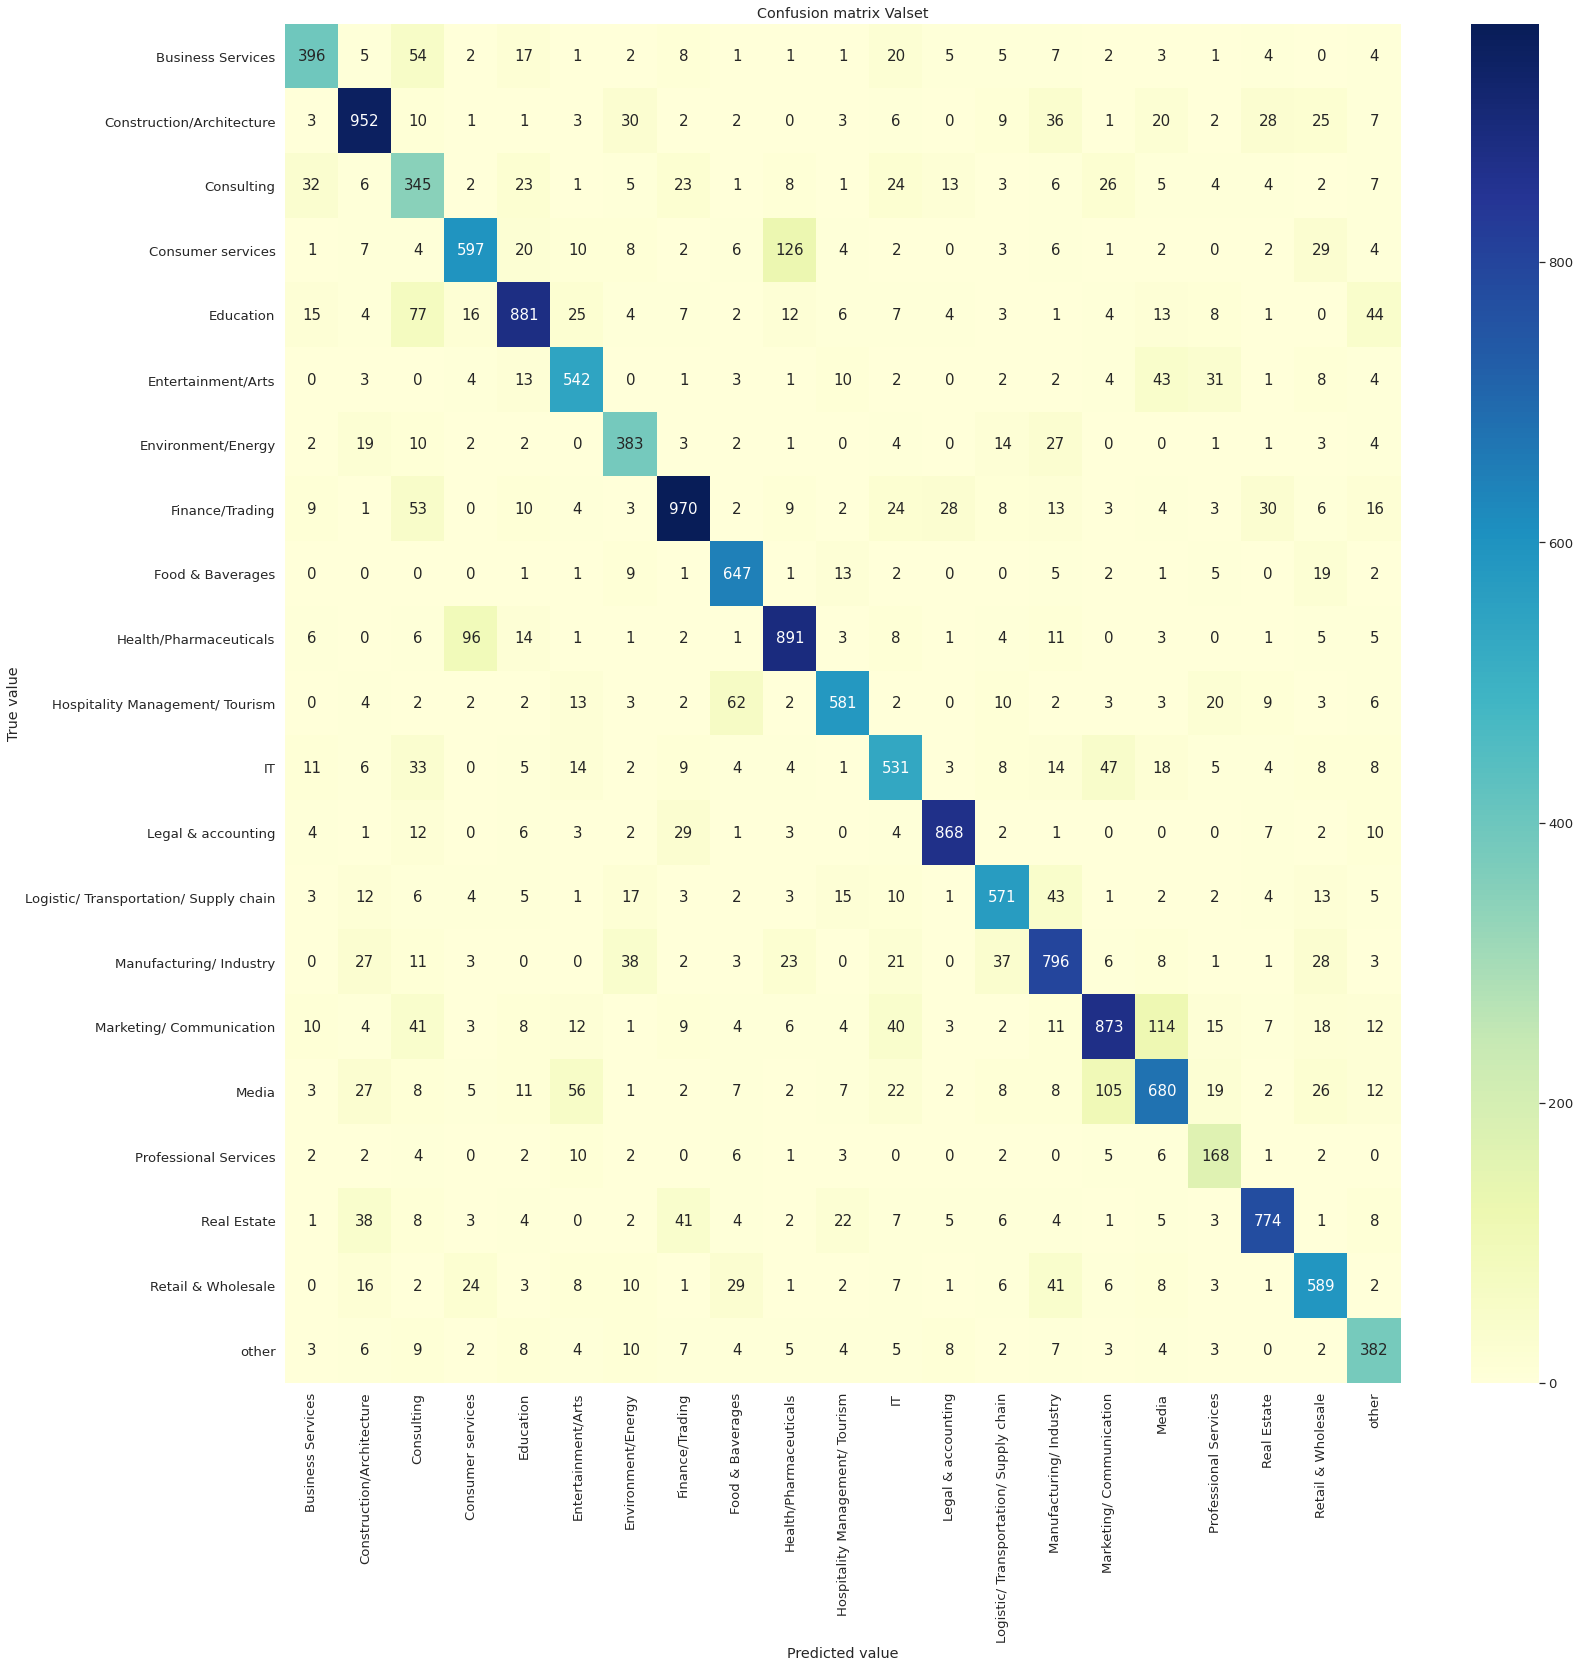

In [ ]:
y_pred = vclf_sgd.predict(x_test)
plot_confusion_matrix(y_test, y_pred, classes)

In [ ]:
y_pred = vclf_sgd.predict(x_test)
plot_confusion_matrix(y_test, y_pred, classes)

In [ ]:
DF[DF['main industry'] == 'other']['industry'].unique()

array(['religious institutions', 'non-profit organization management',
       'individual & family services', 'philanthropy',
       'civic & social organization', 'security and investigations',
       'public safety', 'government relations', 'public policy',
       'think tanks', 'government administration',
       'translation and localization', 'military',
       'museums and institutions', 'political organization'], dtype=object)

In [ ]:
vclf_sgd.classes_.shape

(21,)

In [ ]:
y_pred = vclf_sgd.predict(x_train)
plot_confusion_matrix(y_train, y_pred, classes)

In [ ]:
DF.to_csv('remove_extra_outliers.csv')

In [ ]:
import joblib 

joblib.dump( uni_tfidf ,'vectorizer_79.joblib')

['vectorizer_79.joblib']

In [ ]:
joblib.dump( vclf_sgd ,'model_79.joblib')

['model_79.joblib']

In [ ]:
joblib.dump( model2 ,'model_79.joblib')

In [ ]:
y_pred = vclf_sgd.predict(x_train)
plot_confusion_matrix(y_train, y_pred, classes)

In [ ]:
vclf_sgd.classes_

array(['Business Management', 'Construction/Architecture',
       'Defense/aerospace', 'Edu', 'Entertainment/Arts',
       'Environment/Energy', 'Finance/Trading', 'Food & Baverages',
       'Health/Pharmaceuticals', 'Hospitality Management/ Tourism', 'IT',
       'Legal', 'Logistic/ Transportation', 'Manufacturing/ Machanical',
       'Marketing/Consulting', 'Media', 'Real Estate', 'Retail', 'other'],
      dtype=object)

# BI TF-IDF

In [ ]:
bi_tfidf = TfidfVectorizer()

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=142)
x_train = bi_tfidf.fit_transform(X_train)
x_test = bi_tfidf.transform(X_test)

## SGD Classifier

In [ ]:
from sklearn.linear_model import SGDClassifier
model = SGDClassifier(loss='squared_hinge', penalty="l2", max_iter=200, verbose=0, n_iter_no_change=5, early_stopping=True,  class_weight='balanced', learning_rate='adaptive', eta0=0.001)
model.fit(x_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
              early_stopping=True, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='adaptive', loss='squared_hinge',
              max_iter=200, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
model.score(x_test, y_test)

0.679138500235812

In [ ]:
y_pred = model.predict(x_test)
plot_confusion_matrix(y_test, y_pred, classes)

In [ ]:
x_test_outliers = DF[DF['ratio'] <= 0.03 ]['clean']
y_test_outliers = DF[DF['ratio'] <= 0.03 ]['main industry']
x_test_outliers = bi_tfidf.transform(x_test_outliers)

In [ ]:
y_pred = model.predict(x_test_outliers)
plot_confusion_matrix(y_test_outliers, y_pred, classes)

In [ ]:
DF[DF['ratio'] <= 0.03 ][['clean', 'main industry', 'industry', 'ratio']]

In [ ]:
feature_names = np.array(bi_tfidf.get_feature_names())
show_top10_features(model, feature_names, model.classes_, 200)

In [ ]:
top_features = {}
for i, category in enumerate(classes):
    top10 = np.argsort(model.coef_[i])[-200:]
    #display(Markdown("**%s**: %s" % (category, ", ".join(feature_names[top10]))))
    top_features.update({category : feature_names[top10].tolist()})

IndexError: ignored

In [ ]:

def count_kw(text, labels):
    t = text.split(' ')
    c = 0
    for item in labels:
        if item in t:
            c += 1
    return c
#top_features
DF['count'] = 0
for each in classes:
    labels = top_features[each]
    index = DF.index[ DF['main industry'] == each].tolist()
    for i in index:
        DF.loc[i, ['count']] = count_kw(DF.loc[i]['clean'], labels)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
DF['ratio'] = DF['count'] / DF['len']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


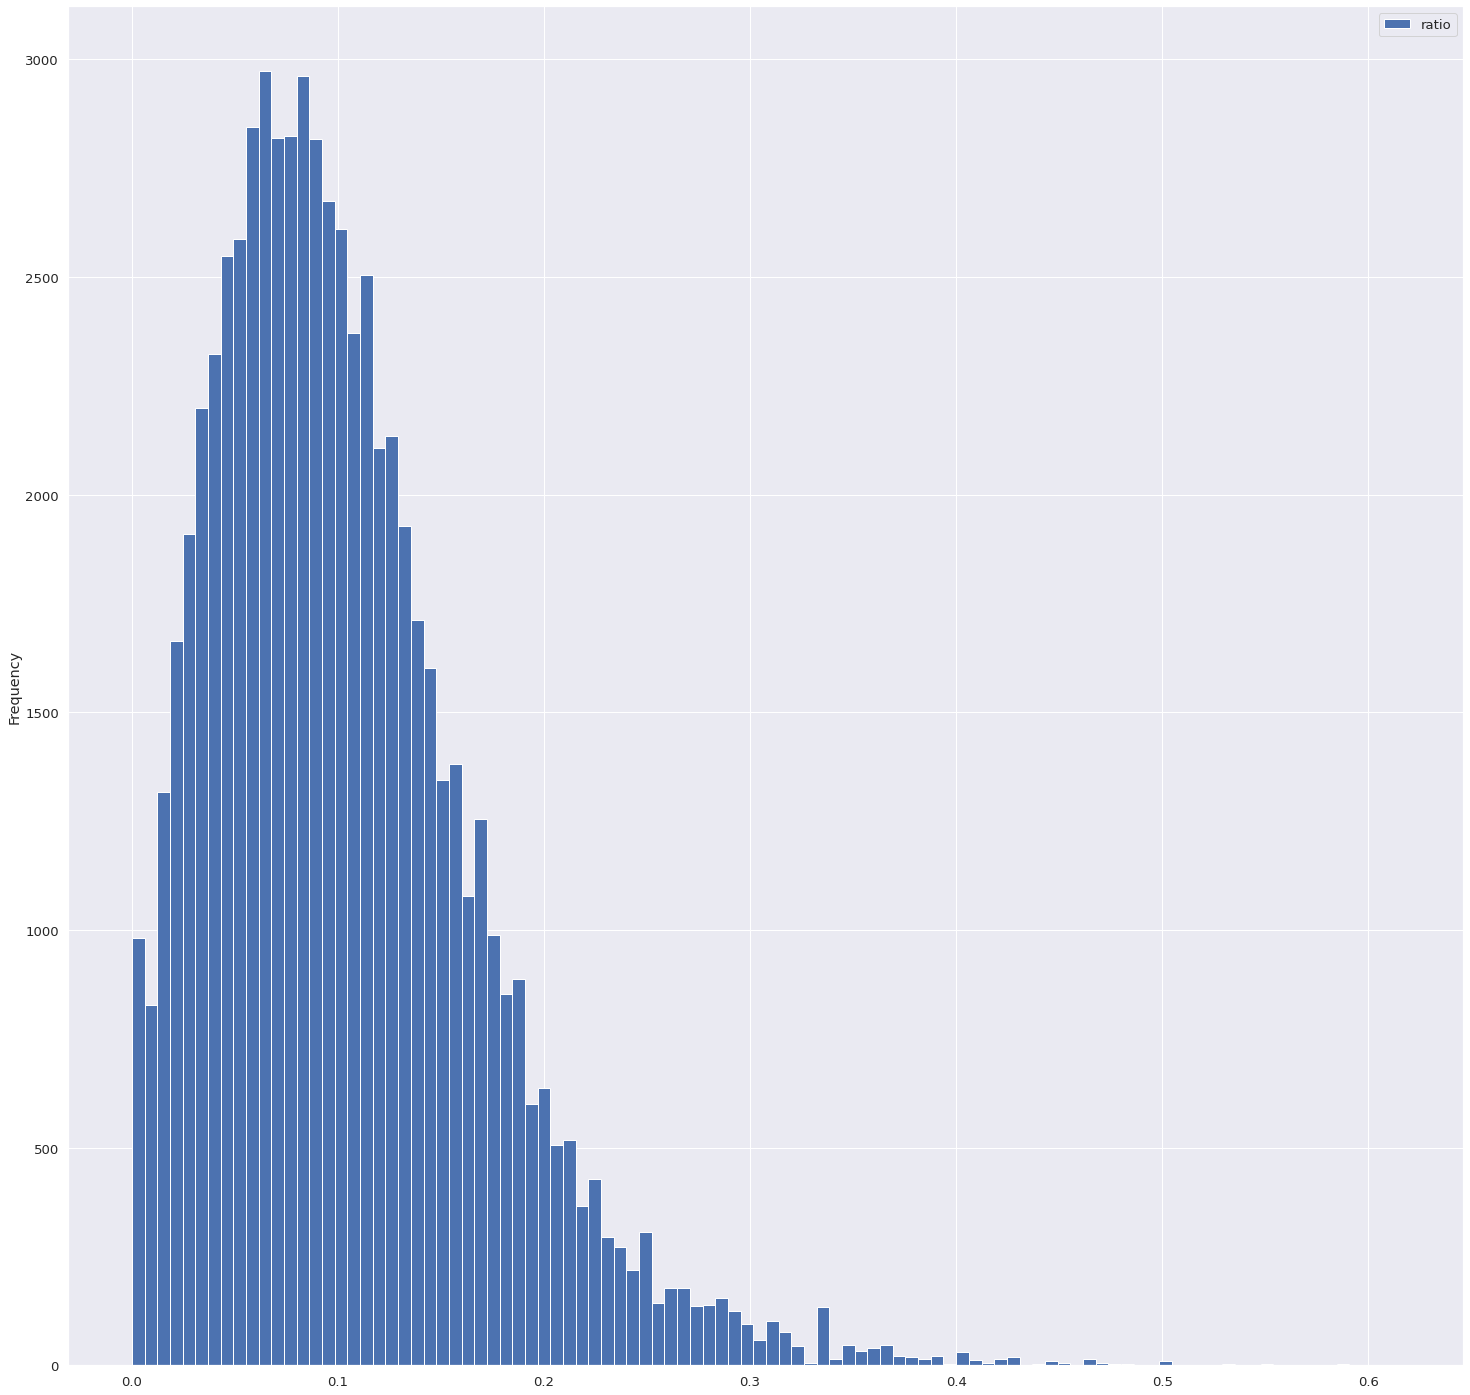

In [ ]:
DF.plot(kind='hist', y='ratio', bins=100)

In [ ]:
DF[DF['ratio'] < 0.01]

Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  ... reject count     ratio
50             50         64005             NaN  ...  False     0  0.000000
125           125          5339             NaN  ...  False     0  0.000000
183           183         10953         10953.0  ...  False     0  0.000000
234           234          7333          7333.0  ...  False     1  0.008130
278           278         28306         28306.0  ...  False     0  0.000000
...           ...           ...             ...  ...    ...   ...       ...
67086       67086         62322             NaN  ...  False     0  0.000000
67094       67094         62802             NaN  ...  False     1  0.009901
67122       67122         68288             NaN  ...  False     1  0.009346
67123       67123         68713             NaN  ...  False     0  0.000000
67147       67147         72357             NaN  ...  False     0  0.000000

[1464 rows x 11 columns]

In [ ]:
top_features['Manufacturing/ Machanical']

In [ ]:
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

--2021-03-24 06:33:22--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.10.214
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.10.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz.1’

GoogleNews-vectors- 100%[===================>]   1.53G  71.7MB/s    in 25s     

2021-03-24 06:33:47 (63.2 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz.1’ saved [1647046227/1647046227]



In [ ]:
import gensim

# Load Google's pre-trained Word2Vec model.
word2vec_path = "/content/GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [ ]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['clean'].apply(lambda x: get_average_word2vec( x.split(' '), vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [ ]:

embeddings = get_word2vec_embeddings(word2vec, __DF)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, y, 
                                                                                        test_size=0.2, random_state=40)

<Figure size 1440x1440 with 0 Axes>

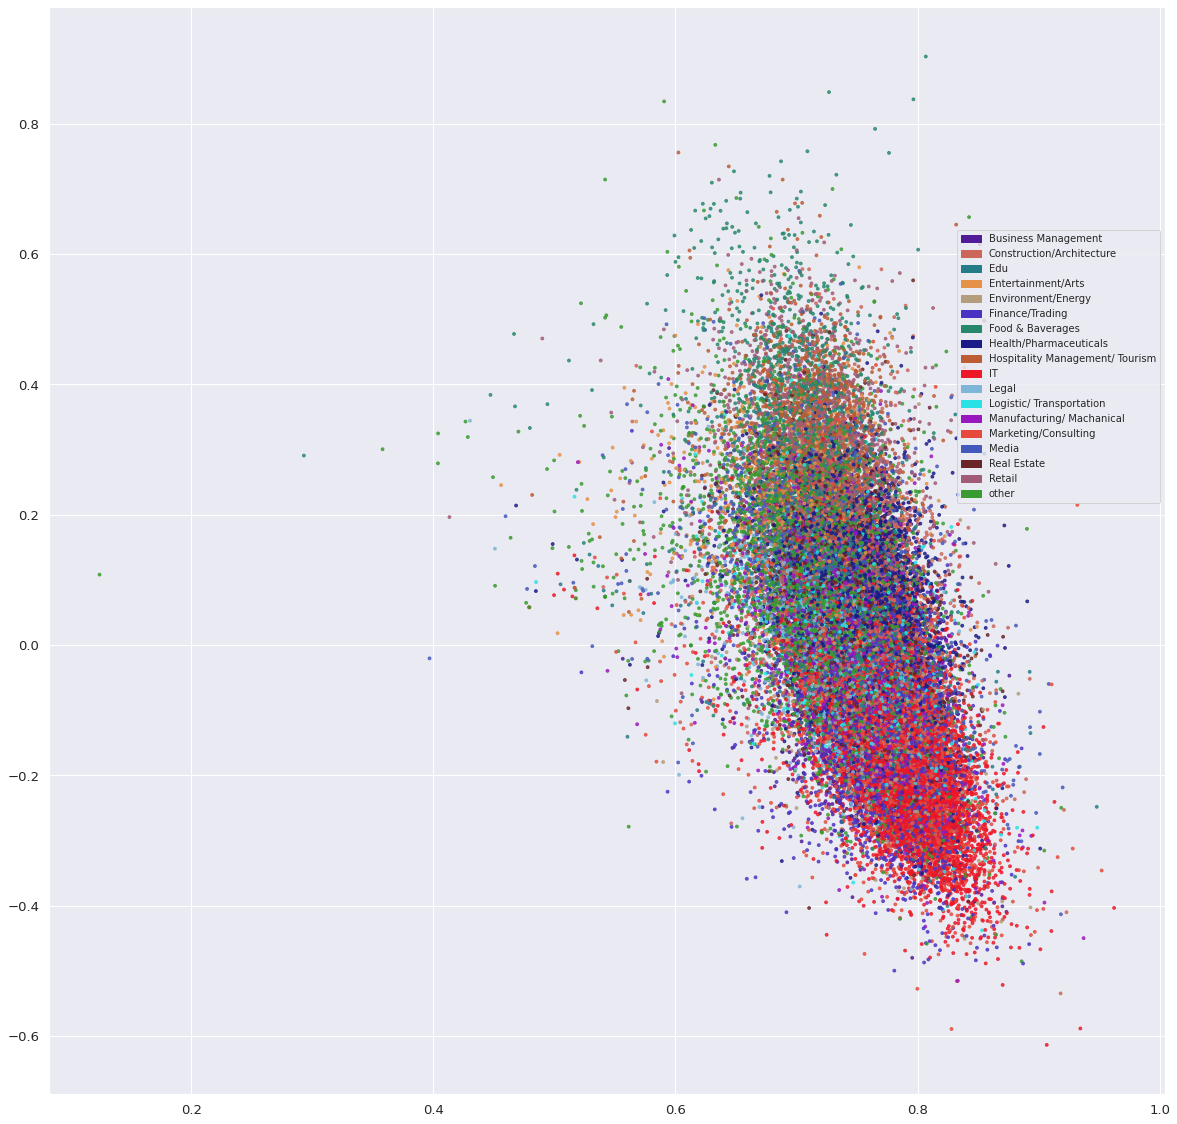

In [ ]:
lsa = TruncatedSVD(n_components= len(classes))
lsa.fit(X_train_word2vec)
lsa_scores = lsa.transform(X_train_word2vec)

fig = plt.figure(figsize=(20, 20))          
plot_LSA_plt(lsa_scores, X_train_word2vec, y_train_word2vec, labels=classes)
plt.show()

Acc = 0.7515820078672824
Report 
                                  precision    recall  f1-score   support

            Business Management       0.64      0.82      0.72       318
      Construction/Architecture       0.83      0.82      0.82       803
                            Edu       0.71      0.76      0.73       664
             Entertainment/Arts       0.58      0.69      0.63       308
             Environment/Energy       0.54      0.72      0.61       230
                Finance/Trading       0.85      0.86      0.85       890
               Food & Baverages       0.77      0.89      0.83       302
         Health/Pharmaceuticals       0.88      0.86      0.87       913
Hospitality Management/ Tourism       0.79      0.89      0.84       325
                             IT       0.79      0.75      0.77      1669
                          Legal       0.81      0.90      0.85       319
       Logistic/ Transportation       0.68      0.71      0.70       366
      Manufactur

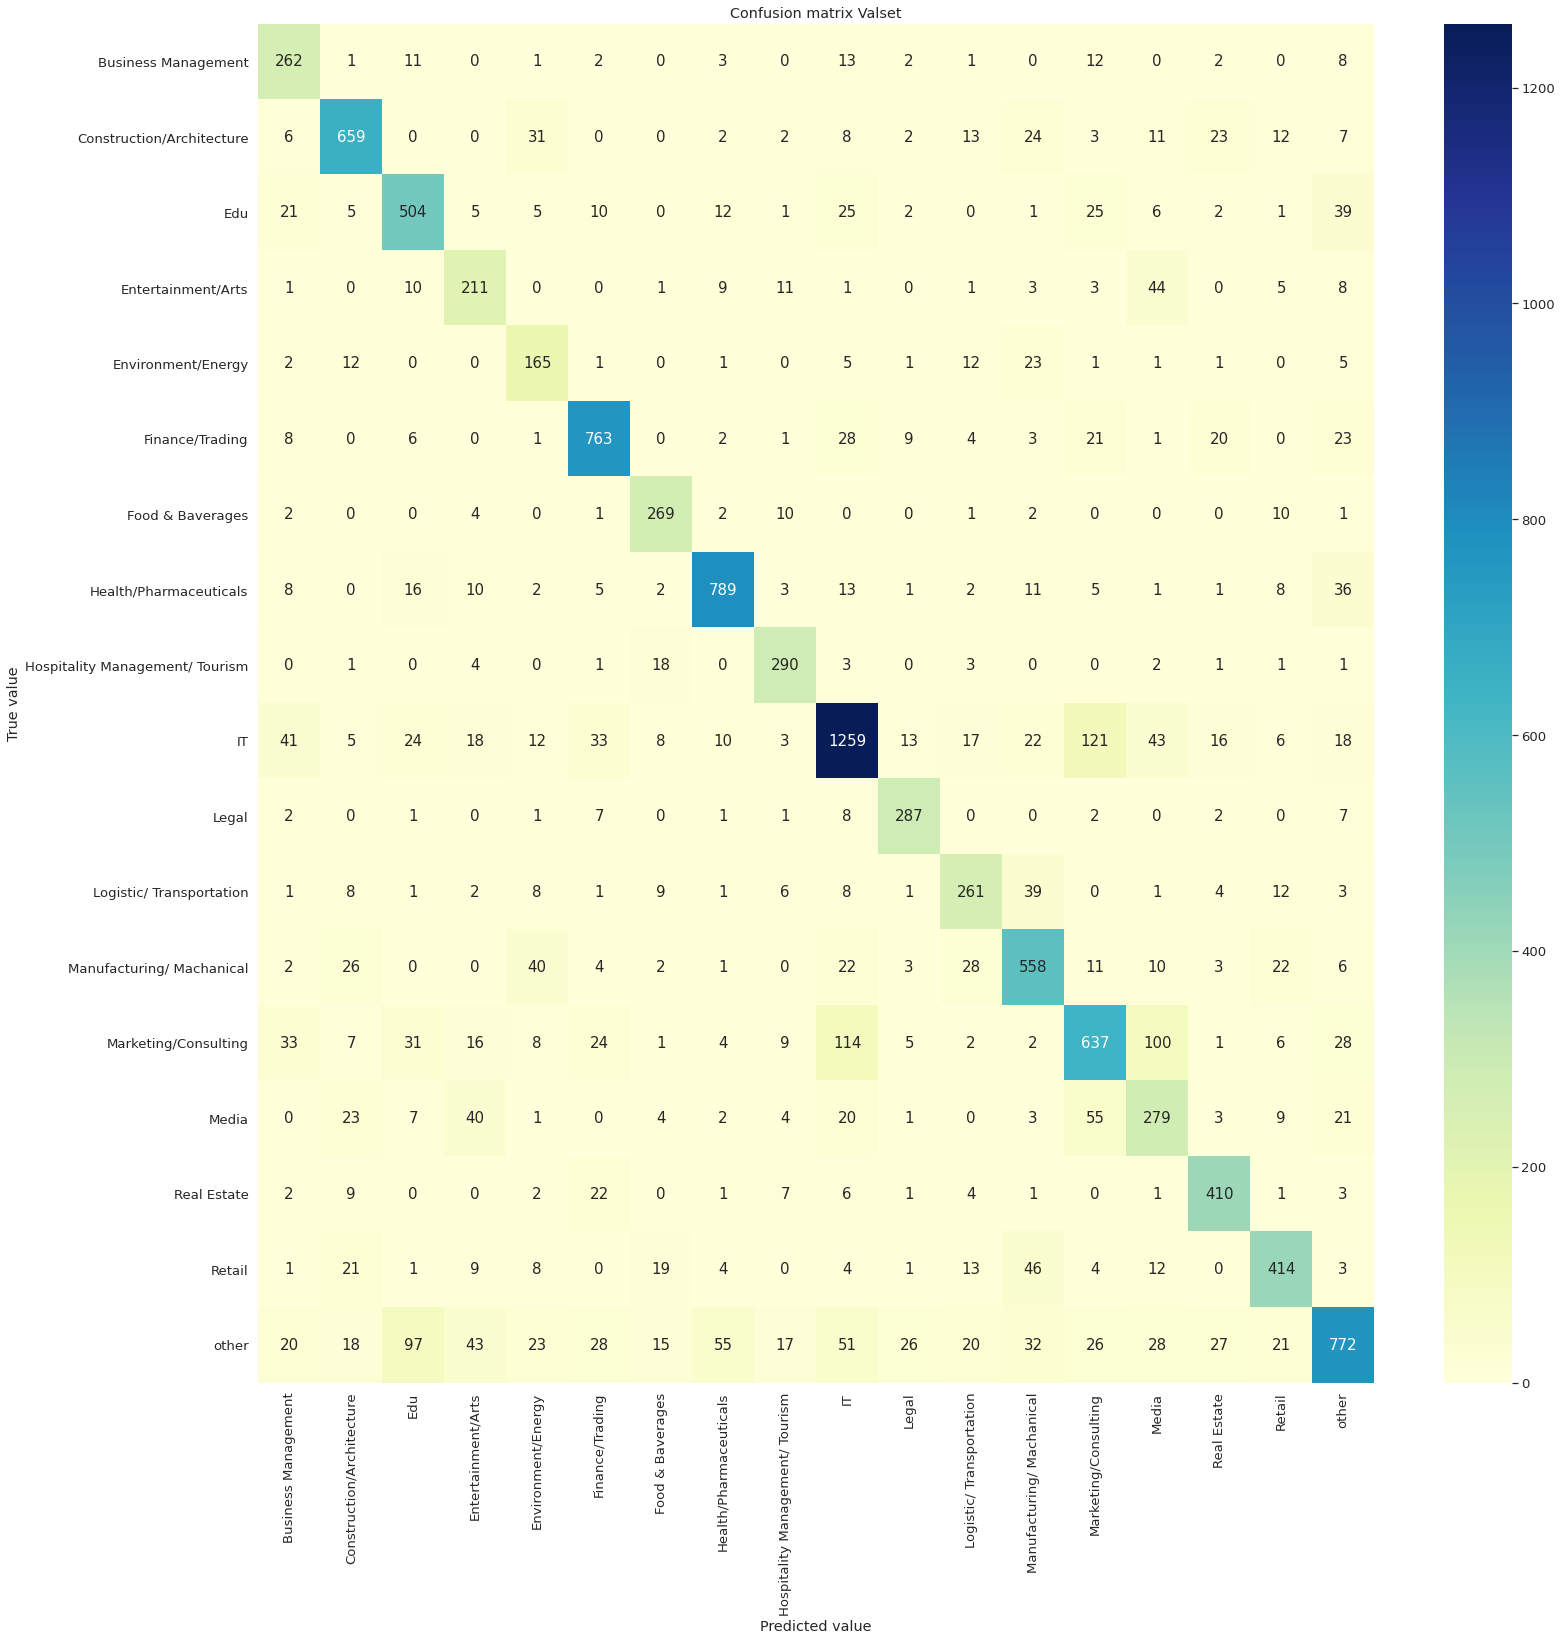

In [ ]:
w2v_vclf_sgd = VotingClassifier(estimators=[
         #('xb6', XGBClassifier(max_depth=6, n_estimators=200, objective='multi:softprob', learning_rate=0.01)),
        #('mb', MultinomialNB(alpha=0.015625)),
        #('sv', SVC(C=60, degree=5)),
        ('lr', LogisticRegression(C=1.3, solver='lbfgs', class_weight='balanced',
                         multi_class='multinomial', max_iter=100, n_jobs=5, random_state=40, verbose=1)),
        ('sgd', SGDClassifier(loss='log', penalty="l2", max_iter=1500, verbose=1, n_iter_no_change=25, early_stopping=True,  class_weight='balanced',
         learning_rate='optimal', eta0=0.1, tol=1e-3) ),
], voting='soft', n_jobs=12)
w2v_vclf_sgd.fit(X_train_word2vec, y_train_word2vec)

y_pred = w2v_vclf_sgd.predict(X_test_word2vec)
plot_confusion_matrix(y_test_word2vec, y_pred, classes)